# **Cost aware BO**
Dec, 2023

Tutorial for Cost aware BO with inclusion of cost based acquistion function in Gpax

-- Notebook prepared by **Arpan Biswas**





### What is it and how this helps?
Cost-aware BO (cBO) is a special BO workflow where the **exploration cost is non-uniform** over the search space. Unlike in any classical BO, in cBO, the acquisiton function considered the cost of exploration of a location in the search space and provide future suggestions based on the trade-off between the value (high mean), uncertainity (high variance) and **cost** of exploration. cBO can be easily combined with structured GP and has been showcased in the tutorials.

**Here is an simple example on how to implement the code for cost aware acquistion function to explore over combinatorial libraies**

Below is a numerical example to represent the combinatorial library exploration. Here, the colors represents separate cells in the library, where time to explore within the cell is lower and increases as sampled from a new cell.

![image](https://github.com/ziatdinovmax/gpax/assets/19354142/593e3a14-db23-43ff-b147-c41da6aad82f)

**Lets define the acqusition function:**

```python3
import jax.numpy as jnp

def cost_acqfun(models, train_data, Data, cost_params, params, ieval, isnorm=False):
    """
    cost based acquisition function- EI based
    Args:
        models: Multi-fidelity and low-fidelity krigging model
        Data: Unexplored data to evaluate for next sample selection in list with actual values and normalized values
        cost_params: Params required for cost aware acquisition function
        params: Params required for standard EI acq function
        ieval: All the current locations explored
        isnorm: If the data need to be normalized. Default is False
    Returns:
        array of acquisition function values, maximum acquistion value location and value
    """
    ....
    # Compute cost on non-normalized data
    prev_x = train_x[-1,:]
    cost = np.zeros_like(standard_acq)
    for i in range(data_real.shape[0]):
        if prev_x[1]==data_real[i,1]:
            cost[i] = t_m + a*np.absolute(data_real[i,0]-prev_x[0])
        else:
            cost[i] = t_m + np.absolute(data_real[i,1]-prev_x[1])*t_c + a*np.absolute(data_real[i,0]-center[int(data_real[i,1])])

    cost_acq = standard_acq/cost

    maxacq_idx = cost_acq.argmax()
    maxacq_val = cost_acq.max()
    nextpt = data_real[maxacq_idx]
    cost_nextpt = cost[maxacq_idx]
    .....
    return cost_acq, maxacq_idx, maxacq_val, cost_nextpt
```

Here, ```t_m, t_c``` are the cost/time to move the probe within the same cell (same color section) and between the cells (next color section). Here, if the probe need to move to a different cell, it goes first to the ```center``` of the cell and then move to the suggested sample location in the new cell. In the BO setting, call the acqusition function as below:

```python3
    t_m = 1
    t_c = 2
    a = 1
    test_data = [X_test, X_test_norm]
    cost_params = [t_m, t_c, a, center]
    acq, next_point_idx, next_point_val,  cost[i-1] = cost_acqfun(gp_model, train_x, test_data, cost_params, rng_key_predict, idx, isnorm=True)
```

**Results for classical BO: Total cost= 42.3**

![image](https://github.com/ziatdinovmax/gpax/assets/19354142/65a053f9-ace4-4797-849f-afab979d0557)

**Result for cost BO: Total cost= 34.5**

![image](https://github.com/ziatdinovmax/gpax/assets/19354142/8b67991e-4cfa-4cca-a06f-77dd4e8d755b)

We can see due to the cost, the acq function tries to gradually exploiting the cells and once the exploitation is done, it focus on exploring the next cell with potential better solution (observed from the jump). The height of the jump denotes the difference between the cells, where moving to the next cell has lesser cost than moving to the farther cells. We can see the total cost for cBO is lower than standard BO for better cost awareness acquisition function. The full example is provided in this notebook.


In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git
!pip install mycolorpy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=8deaa3dfaa558b220166ebd5569037aa1845d807f5793e2f2fa57aa16df96168
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel

import jax
import numpyro
from mycolorpy import colorlist as mcp

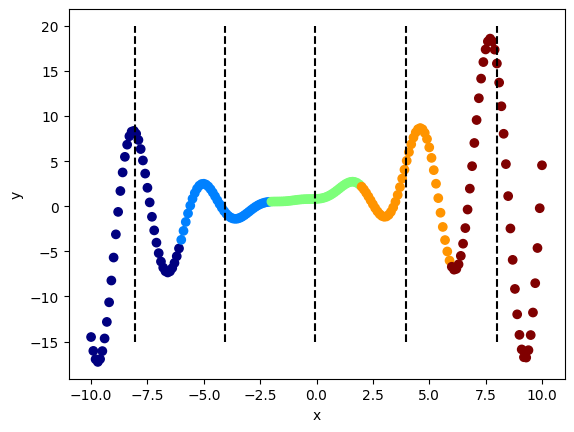

In [ ]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y

lb = -10
ub = 10
cell = np.array((0, 1,  2, 3, 4))

bounds = np.array((lb, ub), dtype=float)

xs = np.linspace(lb, ub, 201)
xs_norm = (xs-lb)/(ub-lb)

ys = objective(xs)
cxs = np.zeros((xs.shape[0], 2))
cxs[:, 0]=xs

for i in range(5):
  cxs[i*40:(i+1)*40 +1, 1]=cell[i]

center=np.zeros(5)
for i in range(5):
  center[i] = (np.max(cxs[cxs[:, 1]==i,0])+np.min(cxs[cxs[:, 1]==i,0]))/2

plt.scatter(cxs[:, 0], ys, c=cxs[:, 1], cmap="jet")
plt.vlines(center, ymin=-15, ymax=20, colors="k", linestyles="dashed")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [ ]:

def cost_acqfun(models, train_data, Data, cost_params, params, ieval, isnorm=False):
    """
    cost based acquisition function- EI based
    Args:
        models: Multi-fidelity and low-fidelity krigging model
        Data: Unexplored data to evaluate for next sample selection in list with actual values and normalized values
        cost_params: Params required for cost aware acquisition function
        params: Params required for standard EI acq function
        ieval: All the current locations explored
        isnorm: If the data need to be normalized. Default is False

    Returns:
        array of acquisition function values, maximum acquistion value location and value
    """

    data_real = Data[0] # True data
    data_norm = Data[1] #Normalize data

    t_m = cost_params[0]
    t_c = cost_params[1]
    a = cost_params[2]
    center = cost_params[3]

    if isnorm == False:
        data = data_real
        # print(data)
    else:
        data = data_norm
        # print(data)

    gp_model = models
    # Compute standard acq function
    standard_acq = gpax.acquisition.EI(params, gp_model, data[:,0], maximize=True, noiseless=True)
    standard_acq = np.array(standard_acq)
    # Check for stability
    standard_acq[np.isnan(standard_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=standard_acq[np.isnan(standard_acq)==True].shape)*1e-3
    # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
    standard_acq[ieval] = 0
    # Compute cost on non-normalized data
    prev_x = train_x[-1,:]
    cost = np.zeros_like(standard_acq)
    for i in range(data_real.shape[0]):
        if prev_x[1]==data_real[i,1]:
            cost[i] = t_m + a*np.absolute(data_real[i,0]-prev_x[0])
        else:
            cost[i] = t_m + np.absolute(data_real[i,1]-prev_x[1])*t_c + a*np.absolute(data_real[i,0]-center[int(data_real[i,1])])

    cost_acq = standard_acq/cost

    maxacq_idx = cost_acq.argmax()
    maxacq_val = cost_acq.max()
    nextpt = data_real[maxacq_idx]
    cost_nextpt = cost[maxacq_idx]

    # Optional- Print acq functions
    plt.plot(data_real[:, 0], cost_acq, label="cost-adjusted acq", c="r")
    plt.plot(data_real[:, 0], standard_acq, label="standard acq", c="b")
    plt.scatter(nextpt[0], maxacq_val, label="next point, cell= "+ str(nextpt[1]), marker = 'X', c="g")
    plt.scatter(prev_x[0], maxacq_val, label="prev point, cell= "+ str(prev_x[1]), marker = 'X', c="k")
    plt.legend(loc="best")
    plt.xlabel("x")
    plt.ylabel("acq_func")
    plt.show()

    return cost_acq, maxacq_idx, maxacq_val, cost_nextpt



# Standard Bayesian Optimization

In [ ]:
n = 10

np.random.seed(1)
train_xs = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_xs_norm = (train_xs-bounds[0])/(bounds[1]-bounds[0])
train_x = np.zeros((train_xs.shape[0], 2))
for i in range(train_xs.shape[0]):
  train_x[i, 0] = train_xs[i]
  if train_xs[i]<=-6:
    train_x[i, 1] = 0
  if train_xs[i]>-6 and train_xs[i]<=-2:
    train_x[i, 1] = 1
  if train_xs[i]>-2 and train_xs[i]<=2:
    train_x[i, 1] = 2
  if train_xs[i]>2 and train_xs[i]<=6:
    train_x[i, 1] = 3
  if train_xs[i]>=6:
    train_x[i, 1] = 4


train_xs, train_xs_norm, train_x

(array([[-1.65955991],
        [ 4.40648987],
        [-9.9977125 ],
        [-3.95334855],
        [-7.06488218],
        [-8.1532281 ],
        [-6.27479577],
        [-3.08878546],
        [-2.06465052],
        [ 0.77633468]]),
 array([[4.17022005e-01],
        [7.20324493e-01],
        [1.14374817e-04],
        [3.02332573e-01],
        [1.46755891e-01],
        [9.23385948e-02],
        [1.86260211e-01],
        [3.45560727e-01],
        [3.96767474e-01],
        [5.38816734e-01]]),
 array([[-1.65955991,  2.        ],
        [ 4.40648987,  3.        ],
        [-9.9977125 ,  0.        ],
        [-3.95334855,  1.        ],
        [-7.06488218,  0.        ],
        [-8.1532281 ,  0.        ],
        [-6.27479577,  0.        ],
        [-3.08878546,  1.        ],
        [-2.06465052,  1.        ],
        [ 0.77633468,  2.        ]]))

In [ ]:
train_y = objective(train_x[:,0])
train_y

array([  0.53107627,   8.21767145, -14.54116764,  -0.95914325,
        -4.46580327,   8.36969808,  -6.11199437,  -0.78035074,
         0.50403247,   1.51095282])

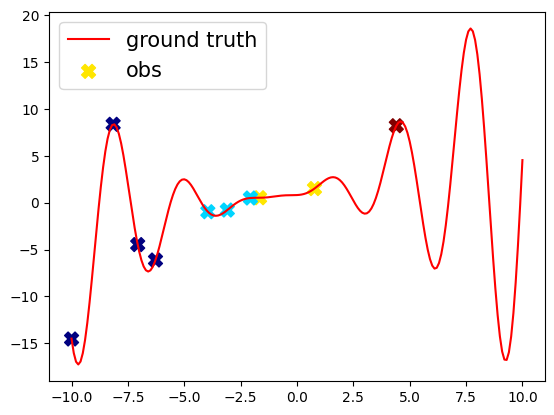

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x[:,0], train_y, c=train_x[:,1], cmap="jet", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
t_m = 1
t_c = 2
a = 1


Step:1


sample: 100%|██████████| 4000/4000 [00:04<00:00, 990.97it/s, 9 steps of size 2.16e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.97      1.14      0.65      0.07      2.05    567.81      1.00
    k_scale     13.17     14.32      5.57      0.05     32.62    128.87      1.01
      noise     14.86     13.59     14.55      0.07     33.43    145.00      1.01



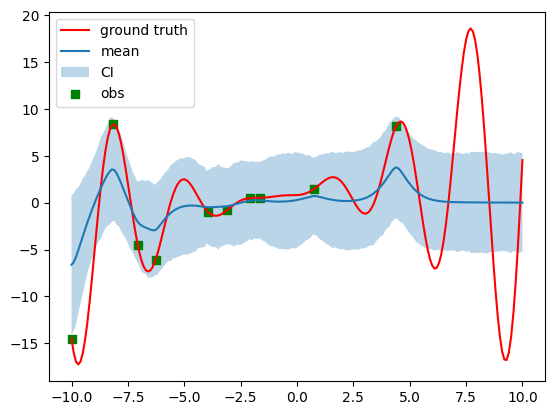

Step:2


sample: 100%|██████████| 4000/4000 [00:04<00:00, 964.91it/s, 7 steps of size 3.57e-01. acc. prob=0.85] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.63      0.52      0.59      0.12      0.94    481.48      1.00
    k_scale     26.02     13.24     24.57      0.19     42.08    473.55      1.00
      noise      3.19      7.59      0.71      0.02      6.61    196.64      1.00



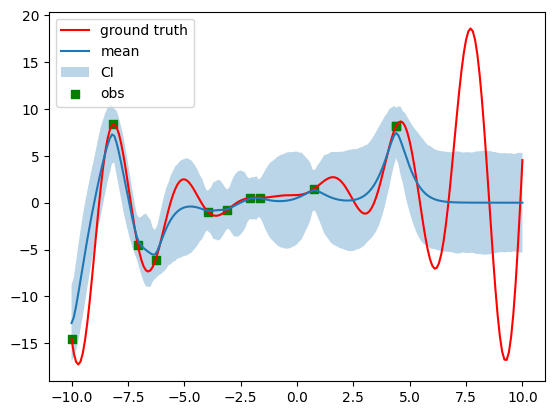

Step:3


sample: 100%|██████████| 4000/4000 [00:04<00:00, 954.55it/s, 7 steps of size 4.39e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.64      0.25      0.64      0.29      0.98    498.97      1.00
    k_scale     26.73     10.47     24.74     12.45     41.92   1006.63      1.00
      noise      1.05      2.67      0.53      0.04      1.92    182.24      1.00



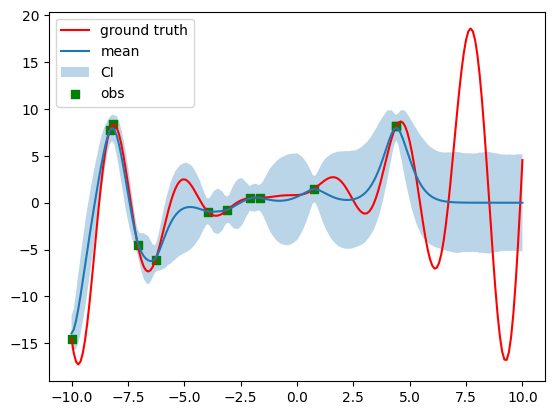

Step:4


sample: 100%|██████████| 4000/4000 [00:04<00:00, 998.09it/s, 7 steps of size 4.72e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.69      0.19      0.70      0.39      1.01   1138.81      1.00
    k_scale     26.75      9.91     24.90     13.05     40.52   1227.36      1.00
      noise      0.76      0.97      0.49      0.03      1.62   1432.94      1.00



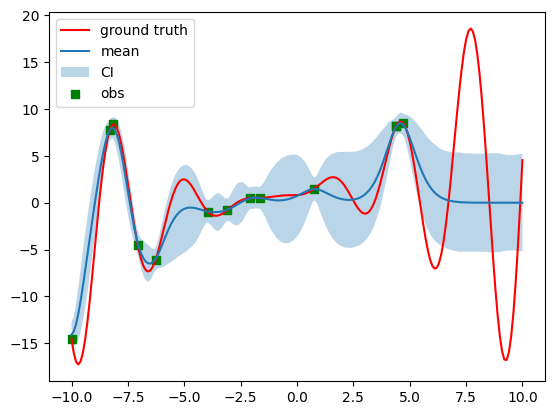

Step:5


sample: 100%|██████████| 4000/4000 [00:04<00:00, 963.38it/s, 7 steps of size 6.29e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.16      0.69      0.44      0.96   1130.44      1.00
    k_scale     26.54     10.32     24.45     12.20     40.65    961.13      1.00
      noise      0.72      0.91      0.47      0.02      1.49   1376.58      1.00



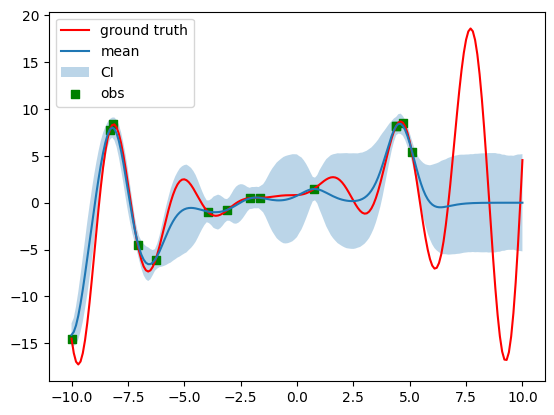

Step:6


sample: 100%|██████████| 4000/4000 [00:04<00:00, 939.76it/s, 7 steps of size 6.21e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.69      0.16      0.68      0.44      0.94   1036.12      1.00
    k_scale     26.58     10.17     24.59     12.95     40.69    957.37      1.00
      noise      0.49      0.58      0.33      0.01      1.02   1389.75      1.00



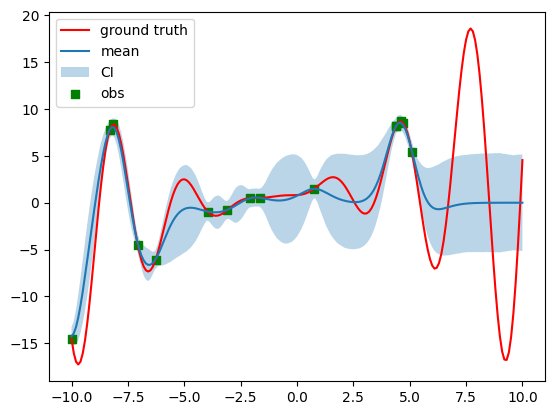

Step:7


sample: 100%|██████████| 4000/4000 [00:04<00:00, 954.89it/s, 7 steps of size 5.32e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.68      0.15      0.68      0.43      0.93   1418.81      1.00
    k_scale     26.20      9.74     24.30     13.17     39.50   1301.50      1.00
      noise      0.30      0.31      0.21      0.01      0.63   1661.93      1.00



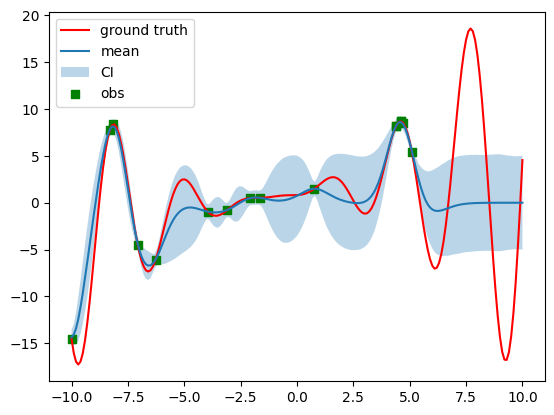

Step:8


sample: 100%|██████████| 4000/4000 [00:03<00:00, 1085.90it/s, 7 steps of size 6.45e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.69      0.14      0.68      0.44      0.90    910.70      1.00
    k_scale     26.62      9.80     24.77     11.82     38.73    952.34      1.00
      noise      0.21      0.26      0.13      0.01      0.45   1521.03      1.00



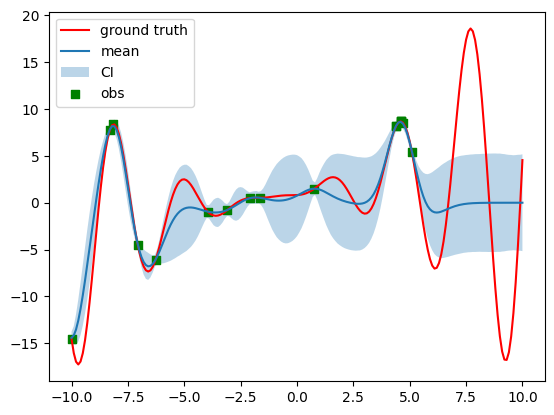

Step:9


sample: 100%|██████████| 4000/4000 [00:05<00:00, 764.02it/s, 7 steps of size 5.02e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.73      0.16      0.73      0.48      0.99   1349.59      1.00
    k_scale     38.71     13.43     35.88     19.73     56.74   1121.70      1.00
      noise      0.21      0.25      0.14      0.01      0.45   1586.32      1.00



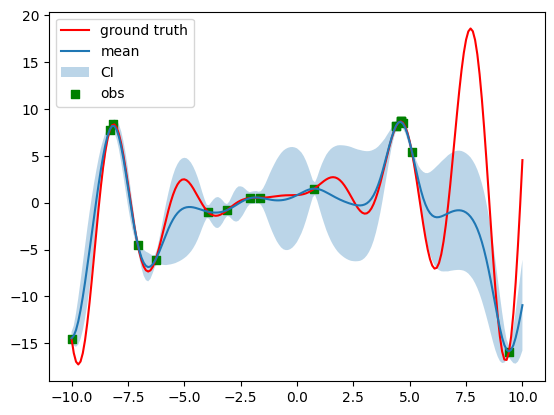

Step:10


sample: 100%|██████████| 4000/4000 [00:04<00:00, 888.58it/s, 7 steps of size 6.82e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.74      0.15      0.75      0.49      0.98   1304.01      1.00
    k_scale     37.76     13.14     34.88     19.99     57.22   1062.27      1.00
      noise      0.21      0.24      0.13      0.00      0.44   1288.09      1.00



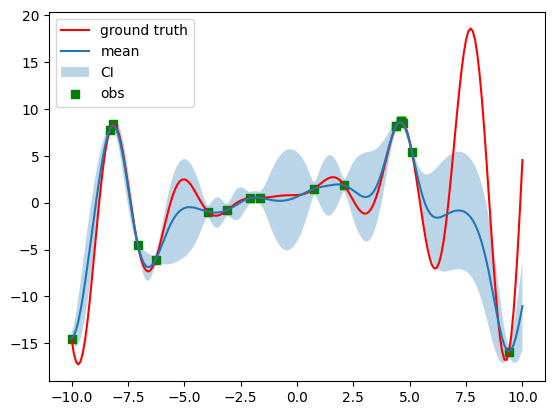

Step:11


sample: 100%|██████████| 4000/4000 [00:04<00:00, 948.34it/s, 7 steps of size 5.21e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.72      0.14      0.72      0.49      0.97   1339.68      1.00
    k_scale     44.01     14.21     41.58     23.52     63.18   1406.30      1.00
      noise      0.20      0.23      0.14      0.01      0.45   1655.12      1.00



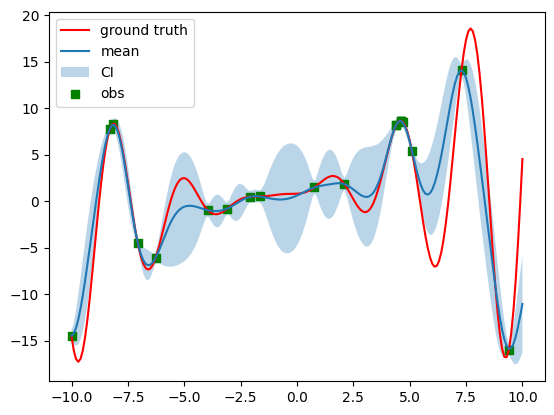

Step:12


sample: 100%|██████████| 4000/4000 [00:04<00:00, 903.75it/s, 7 steps of size 5.57e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.61      0.15      0.61      0.38      0.85   1403.02      1.00
    k_scale     46.14     14.87     43.27     24.08     66.96   1157.33      1.00
      noise      0.26      0.35      0.16      0.01      0.55   1315.28      1.00



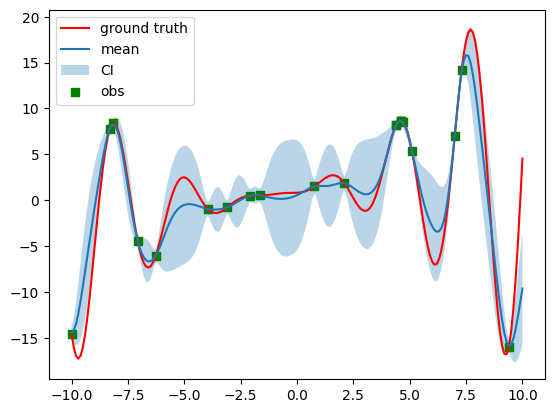

Step:13


sample: 100%|██████████| 4000/4000 [00:04<00:00, 850.29it/s, 7 steps of size 5.66e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.13      0.70      0.49      0.92   1302.27      1.00
    k_scale     50.41     16.62     47.29     26.01     72.76   1165.24      1.00
      noise      0.20      0.22      0.13      0.01      0.44   1390.95      1.00



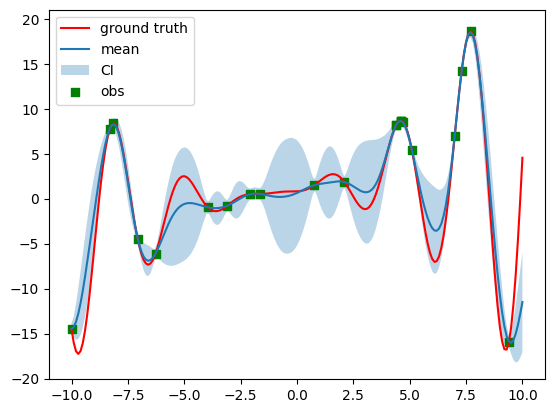

Step:14


sample: 100%|██████████| 4000/4000 [00:04<00:00, 825.40it/s, 7 steps of size 6.37e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.71      0.13      0.70      0.49      0.91   1282.97      1.00
    k_scale     50.56     17.36     47.12     26.23     71.89    944.59      1.00
      noise      0.12      0.15      0.08      0.00      0.27   1408.41      1.00



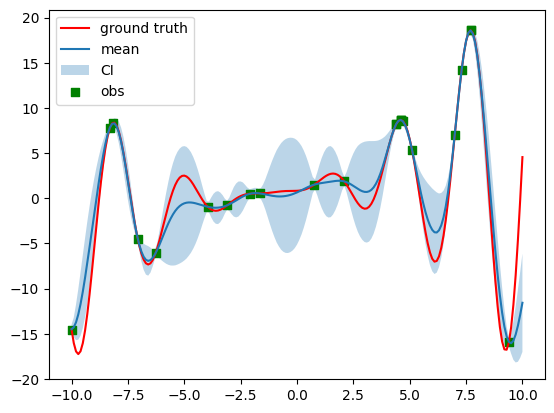

Step:15


sample: 100%|██████████| 4000/4000 [00:04<00:00, 895.62it/s, 15 steps of size 4.83e-01. acc. prob=0.96]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.71      0.13      0.70      0.49      0.91   1213.17      1.00
    k_scale     49.96     16.62     46.64     26.26     73.33    993.15      1.00
      noise      0.08      0.09      0.05      0.00      0.17   1651.55      1.00



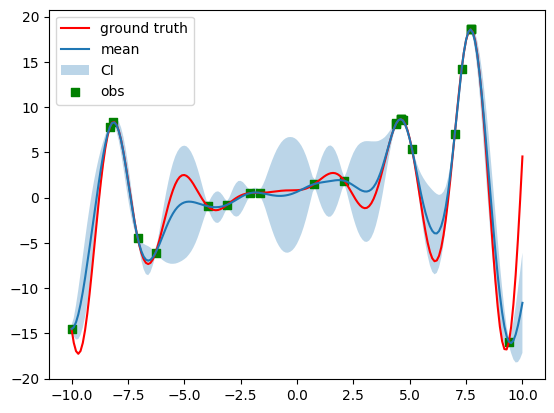

In [ ]:
N = 15
X_test =cxs
X_test_full = cxs

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
cost = np.zeros(N)
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x[:, 0], train_y)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test[:, 0])
        plt.plot(xs, ys, label="ground truth", c="r")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        plt.plot(xs, y_pred, label="mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI",
        )
        plt.scatter(train_x[:, 0], train_y, c="g", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test[:, 0], maximize=True, noiseless=True)
    next_point_idx = acq.argmax()
    next_point_val = acq.max()
    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        train_y = objective(train_x[:, 0])

    # Compute cost
    prev_x = train_x[-2,:]
    new_x = train_x[-1,:]
    if prev_x[1]==new_x[1]:
        cost[i-1] = t_m + a*np.absolute(new_x[0]-prev_x[0])
    else:
        cost[i-1] = t_m + np.absolute(new_x[1]-prev_x[1])*t_c + a*np.absolute(new_x[0]-center[int(new_x[1])])
    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

42.3


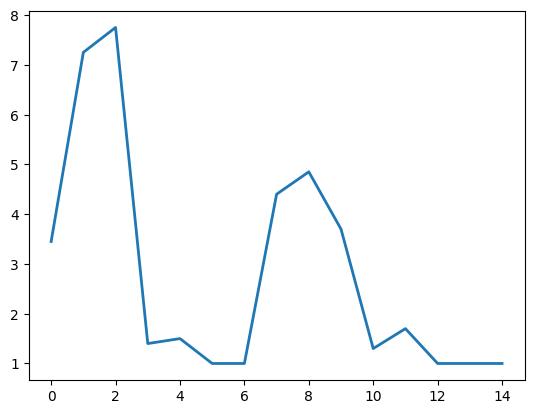

In [ ]:
total_cost= np.sum(cost)
print(total_cost)
plt.plot(cost, linewidth=2)

# Cost aware Bayesian Optimization

Initial Sampling- 10 samples

In [ ]:
n = 10

np.random.seed(1)
train_xs = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_xs_norm = (train_xs-bounds[0])/(bounds[1]-bounds[0])
train_x = np.zeros((train_xs.shape[0], 2))
train_x_norm = np.zeros((train_xs_norm.shape[0], 2))
for i in range(train_xs.shape[0]):
  train_x[i, 0] = train_xs[i]
  train_x_norm[i, 0] = train_xs_norm[i]
  if train_xs[i]<=-6:
    train_x[i, 1] = 0
    train_x_norm[i, 1] = 0
  if train_xs[i]>-6 and train_xs[i]<=-2:
    train_x[i, 1] = 1
    train_x_norm[i, 1] = 1
  if train_xs[i]>-2 and train_xs[i]<=2:
    train_x[i, 1] = 2
    train_x_norm[i, 1] = 2
  if train_xs[i]>2 and train_xs[i]<=6:
    train_x[i, 1] = 3
    train_x_norm[i, 1] = 3
  if train_xs[i]>=6:
    train_x[i, 1] = 4
    train_x_norm[i, 1] = 4


train_xs, train_xs_norm, train_x, train_x_norm

(array([[-1.65955991],
        [ 4.40648987],
        [-9.9977125 ],
        [-3.95334855],
        [-7.06488218],
        [-8.1532281 ],
        [-6.27479577],
        [-3.08878546],
        [-2.06465052],
        [ 0.77633468]]),
 array([[4.17022005e-01],
        [7.20324493e-01],
        [1.14374817e-04],
        [3.02332573e-01],
        [1.46755891e-01],
        [9.23385948e-02],
        [1.86260211e-01],
        [3.45560727e-01],
        [3.96767474e-01],
        [5.38816734e-01]]),
 array([[-1.65955991,  2.        ],
        [ 4.40648987,  3.        ],
        [-9.9977125 ,  0.        ],
        [-3.95334855,  1.        ],
        [-7.06488218,  0.        ],
        [-8.1532281 ,  0.        ],
        [-6.27479577,  0.        ],
        [-3.08878546,  1.        ],
        [-2.06465052,  1.        ],
        [ 0.77633468,  2.        ]]),
 array([[4.17022005e-01, 2.00000000e+00],
        [7.20324493e-01, 3.00000000e+00],
        [1.14374817e-04, 0.00000000e+00],
        [3.0233257

In [ ]:
train_y = objective(train_x[:,0])
train_y

array([  0.53107627,   8.21767145, -14.54116764,  -0.95914325,
        -4.46580327,   8.36969808,  -6.11199437,  -0.78035074,
         0.50403247,   1.51095282])

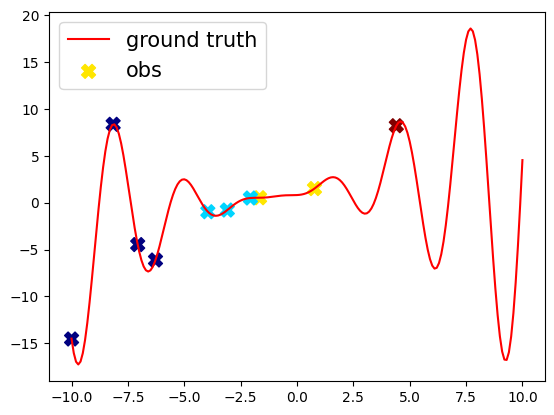

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x[:,0], train_y, c=train_x[:,1], cmap="jet", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

Run BO- 15 iterations

In [ ]:
t_m = 1
t_c = 2
a = 1

Step:1


sample: 100%|██████████| 4000/4000 [00:03<00:00, 1059.64it/s, 7 steps of size 7.55e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.50      1.91      0.95      0.06      3.19   1436.69      1.00
    k_scale      1.58      2.07      0.97      0.08      3.57   1657.48      1.00
      noise     27.53     10.81     25.58     13.81     42.37   1283.91      1.00



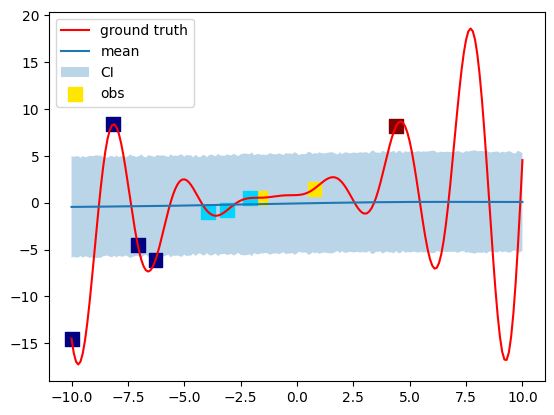

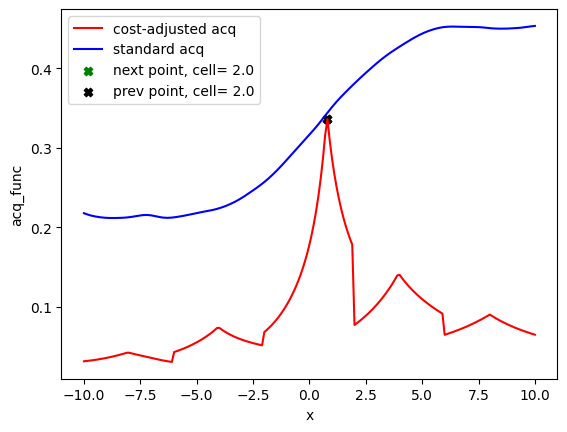

108
Step:2


sample: 100%|██████████| 4000/4000 [00:04<00:00, 941.33it/s, 7 steps of size 6.87e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.49      1.99      0.87      0.05      3.25   1182.11      1.00
    k_scale      1.55      1.87      0.96      0.05      3.52   1385.21      1.00
      noise     26.26      9.97     24.30     12.26     39.59   1599.20      1.00



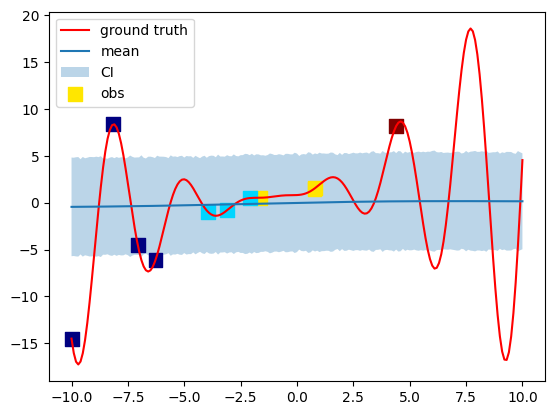

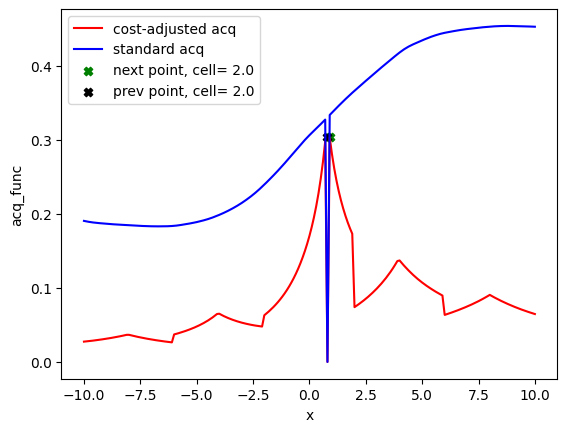

[108 109]
Step:3


sample: 100%|██████████| 4000/4000 [00:04<00:00, 951.84it/s, 3 steps of size 7.90e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.41      1.83      0.84      0.07      3.07   1413.07      1.00
    k_scale      1.55      1.87      1.00      0.05      3.36   1468.24      1.00
      noise     24.77      9.06     23.22     11.39     36.22   1697.81      1.00



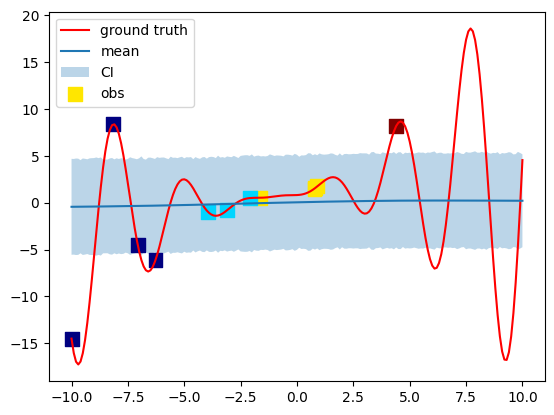

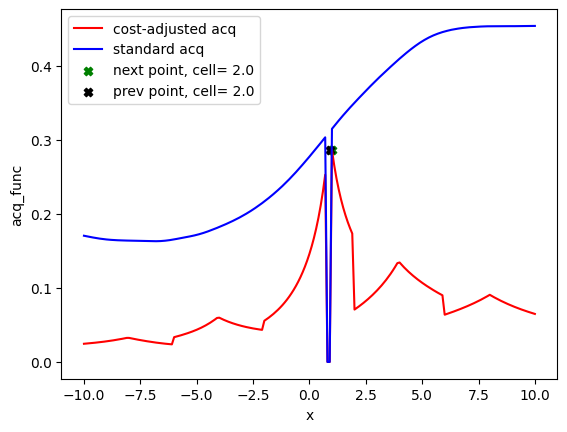

[108 109 110]
Step:4


sample: 100%|██████████| 4000/4000 [00:04<00:00, 925.38it/s, 7 steps of size 7.37e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.38      1.88      0.80      0.05      2.94   1270.81      1.00
    k_scale      1.64      2.06      1.01      0.04      3.62   1335.31      1.00
      noise     23.40      8.07     21.80     11.00     34.75   1585.61      1.00



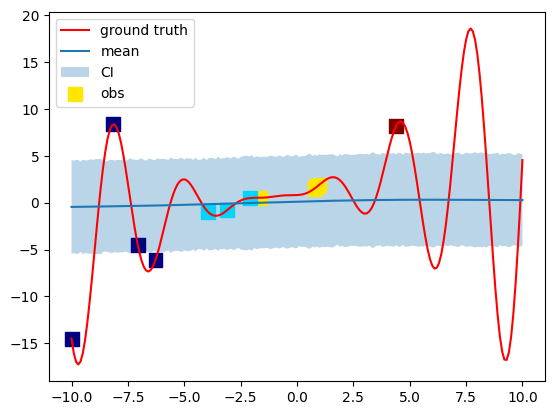

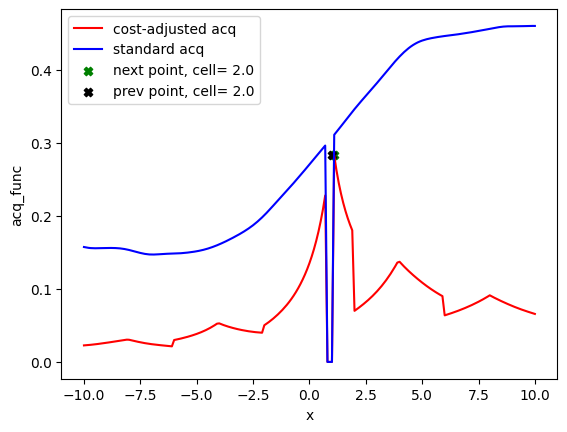

[108 109 110 111]
Step:5


sample: 100%|██████████| 4000/4000 [00:04<00:00, 921.21it/s, 7 steps of size 8.66e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.46      2.04      0.83      0.07      3.21   1377.35      1.00
    k_scale      1.65      2.16      0.99      0.05      3.63   1383.79      1.00
      noise     22.96      8.18     21.28     11.00     34.10   1865.69      1.00



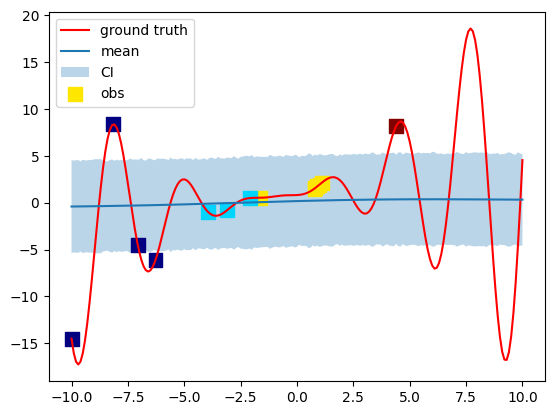

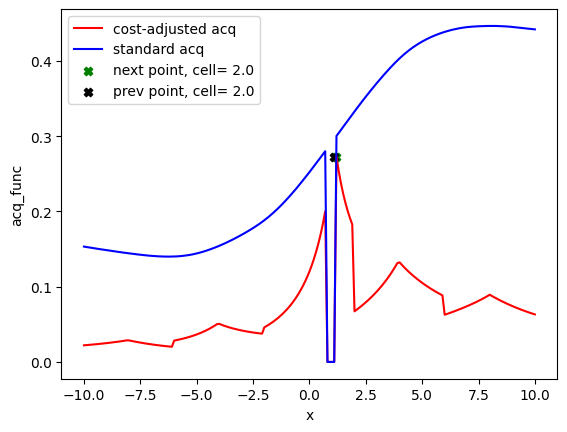

[108 109 110 111 112]
Step:6


sample: 100%|██████████| 4000/4000 [00:05<00:00, 764.99it/s, 3 steps of size 7.99e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.31      1.82      0.76      0.05      2.87   1398.46      1.00
    k_scale      1.78      2.30      1.05      0.03      3.92   1134.24      1.00
      noise     21.63      7.48     20.19     10.70     31.73   1678.47      1.00



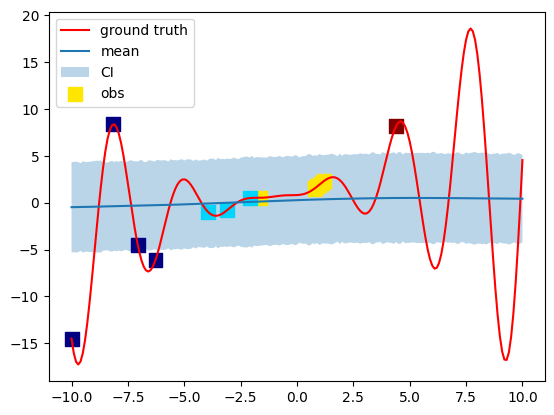

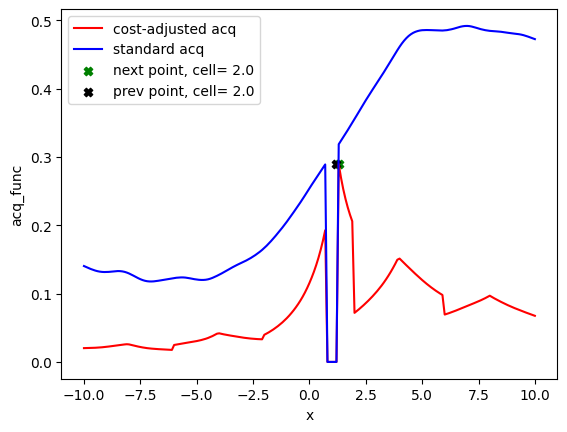

[108 109 110 111 112 113]
Step:7


sample: 100%|██████████| 4000/4000 [00:04<00:00, 916.64it/s, 1 steps of size 7.62e-01. acc. prob=0.44] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.73      1.52      0.06      0.02      2.09     14.25      1.23
    k_scale     15.98     16.51     14.06      0.13     41.09      3.84      1.92
      noise     10.48     11.32      2.62      0.15     26.00      3.19      2.70



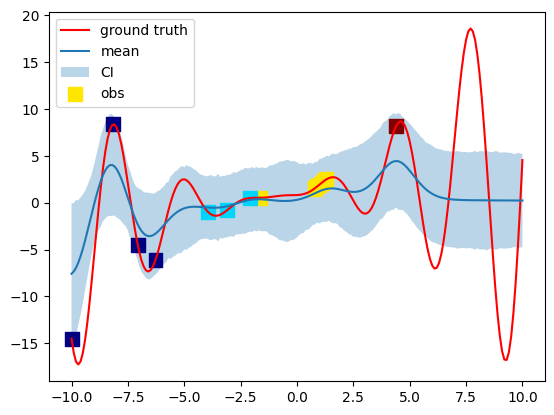

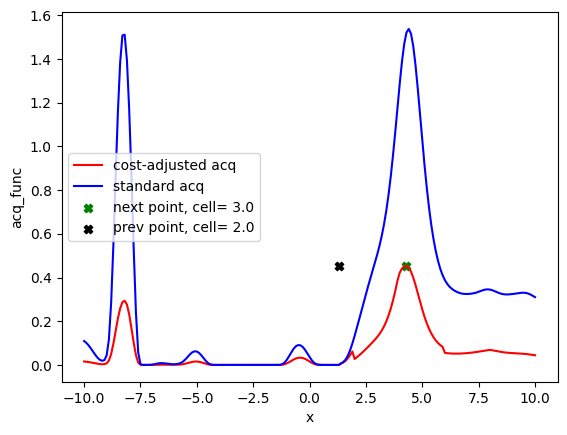

[108 109 110 111 112 113 143]
Step:8


sample: 100%|██████████| 4000/4000 [00:04<00:00, 906.70it/s, 3 steps of size 7.06e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.20      1.76      0.63      0.03      2.54   1063.78      1.00
    k_scale      2.30      3.09      1.27      0.03      5.22    970.24      1.00
      noise     21.36      7.29     20.22     10.78     31.33   1321.56      1.00



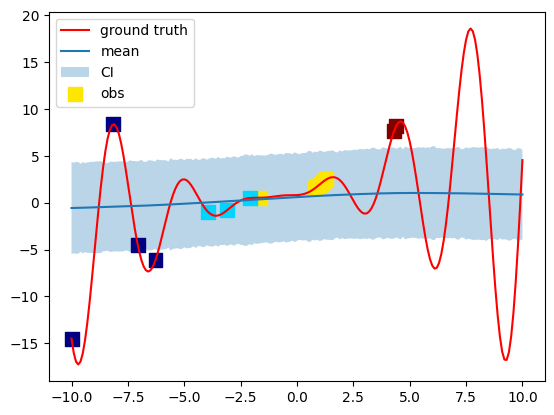

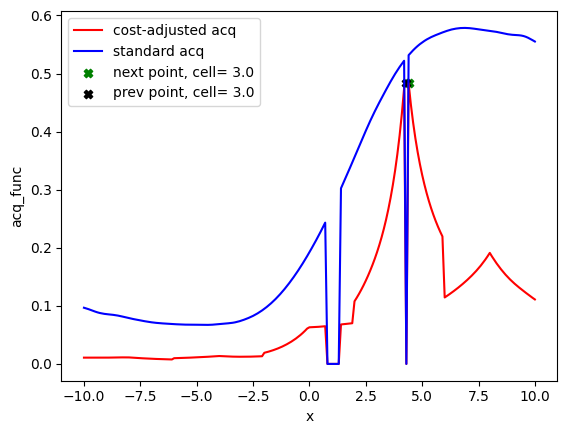

[108 109 110 111 112 113 143 144]
Step:9


sample: 100%|██████████| 4000/4000 [00:04<00:00, 942.49it/s, 7 steps of size 5.78e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.04      0.01      0.04      0.03      0.06   1157.16      1.00
    k_scale     30.92     12.85     27.95     13.63     48.13    951.68      1.00
      noise      0.10      0.12      0.07      0.00      0.21   1436.27      1.00



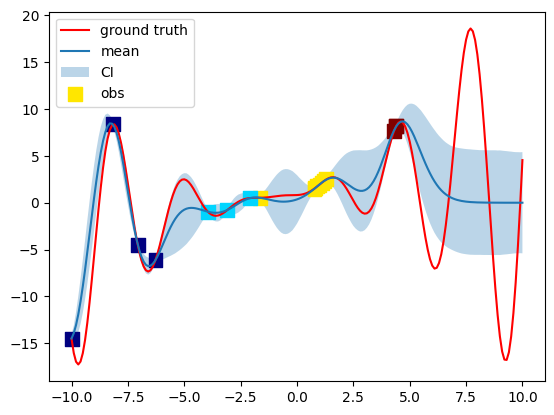

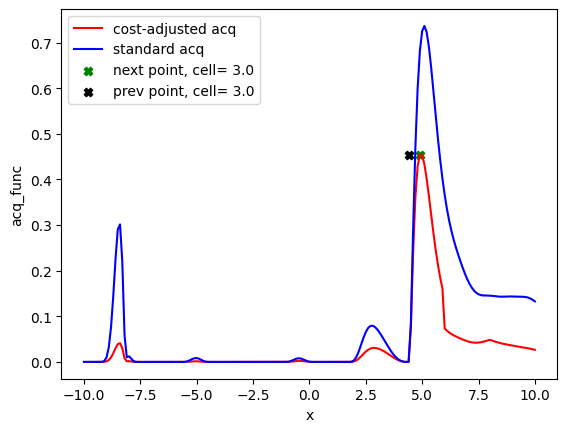

[108 109 110 111 112 113 143 144 149]
Step:10


sample: 100%|██████████| 4000/4000 [00:04<00:00, 857.68it/s, 15 steps of size 4.93e-01. acc. prob=0.96]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.04      0.01      0.04      0.03      0.05   1249.66      1.00
    k_scale     28.78     11.42     26.35     12.72     43.23   1150.14      1.00
      noise      0.11      0.13      0.07      0.00      0.22   1243.16      1.00



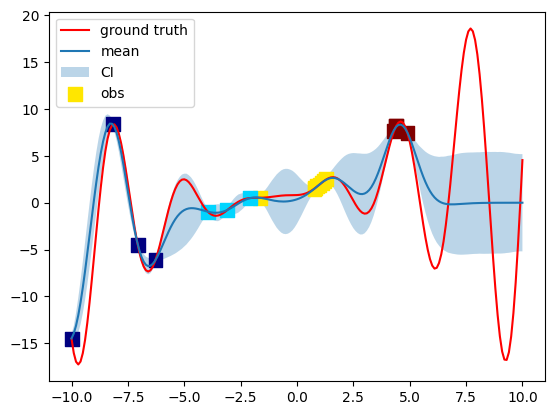

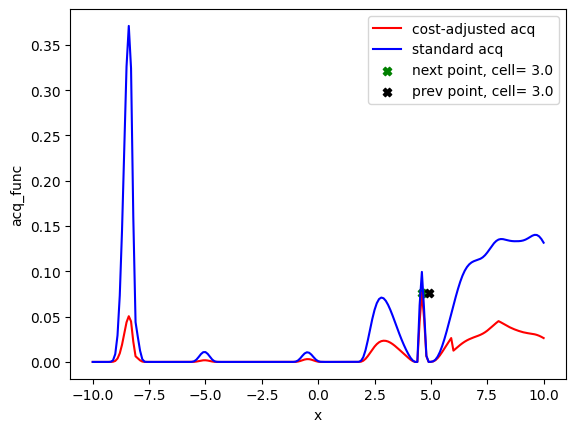

[108 109 110 111 112 113 143 144 149 146]
Step:11


sample: 100%|██████████| 4000/4000 [00:04<00:00, 891.15it/s, 7 steps of size 7.47e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.04      0.01      0.04      0.03      0.05    990.37      1.00
    k_scale     29.02     11.45     26.25     13.07     44.43    978.78      1.00
      noise      0.08      0.09      0.05      0.00      0.17   1253.50      1.00



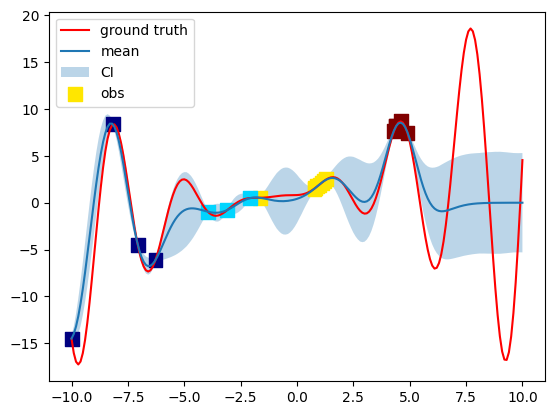

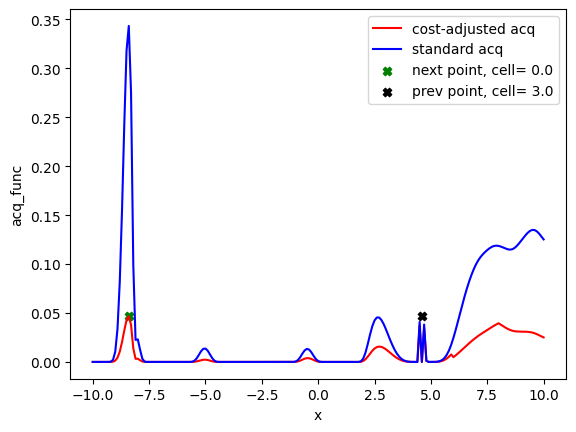

[108 109 110 111 112 113 143 144 149 146  16]
Step:12


sample: 100%|██████████| 4000/4000 [00:04<00:00, 875.23it/s, 7 steps of size 6.30e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.04      0.01      0.04      0.03      0.05   1579.96      1.00
    k_scale     27.19     10.01     25.16     12.96     40.93   1256.18      1.00
      noise      0.08      0.10      0.05      0.00      0.17   1422.38      1.00



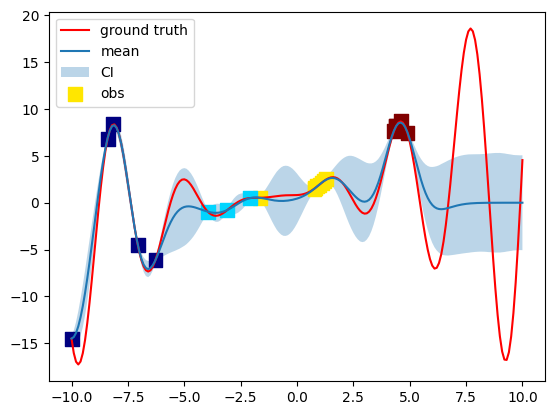

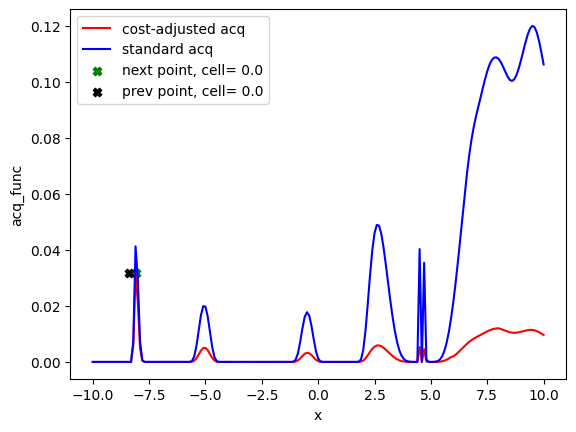

[108 109 110 111 112 113 143 144 149 146  16  19]
Step:13


sample: 100%|██████████| 4000/4000 [00:04<00:00, 855.09it/s, 7 steps of size 5.28e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.04      0.01      0.04      0.03      0.05   1239.11      1.00
    k_scale     27.00      9.99     24.89     13.09     40.58   1124.74      1.00
      noise      0.05      0.06      0.03      0.00      0.11   1559.15      1.00



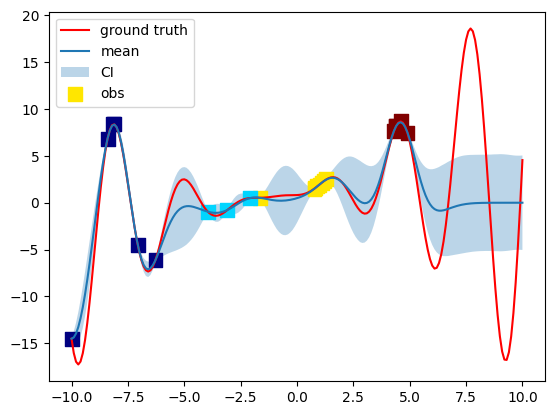

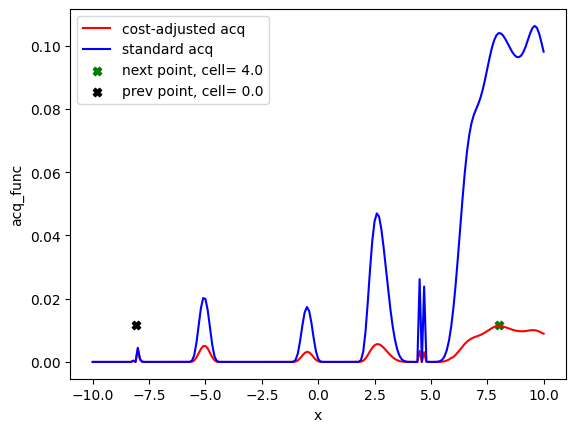

[108 109 110 111 112 113 143 144 149 146  16  19 180]
Step:14


sample: 100%|██████████| 4000/4000 [00:07<00:00, 563.91it/s, 7 steps of size 5.42e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.04      0.01      0.04      0.03      0.05   1326.88      1.00
    k_scale     39.55     14.12     36.74     19.23     58.64   1071.76      1.00
      noise      0.05      0.06      0.03      0.00      0.12   1549.76      1.00



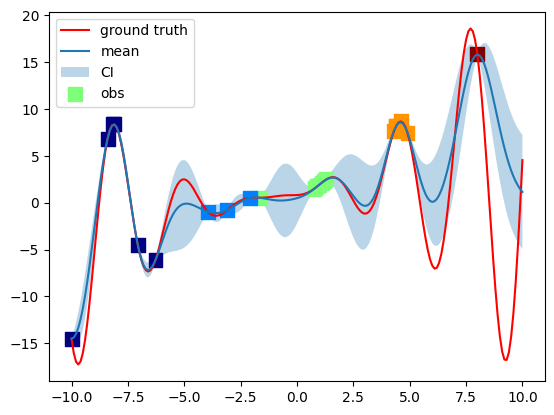

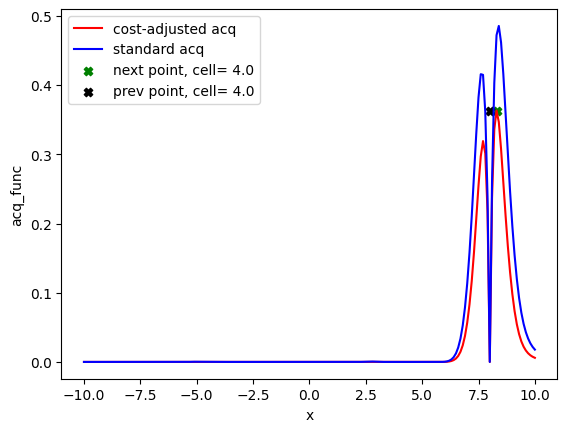

[108 109 110 111 112 113 143 144 149 146  16  19 180 183]
Step:15


sample: 100%|██████████| 4000/4000 [00:06<00:00, 577.45it/s, 7 steps of size 5.55e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.04      0.01      0.04      0.03      0.05   1247.93      1.00
    k_scale     45.89     16.47     43.08     21.64     68.30   1138.69      1.00
      noise      0.06      0.07      0.04      0.00      0.13   1041.80      1.00



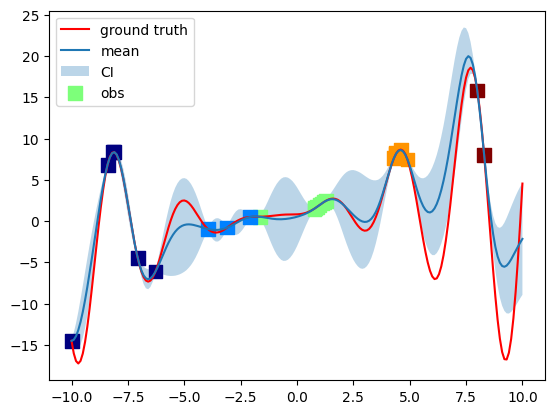

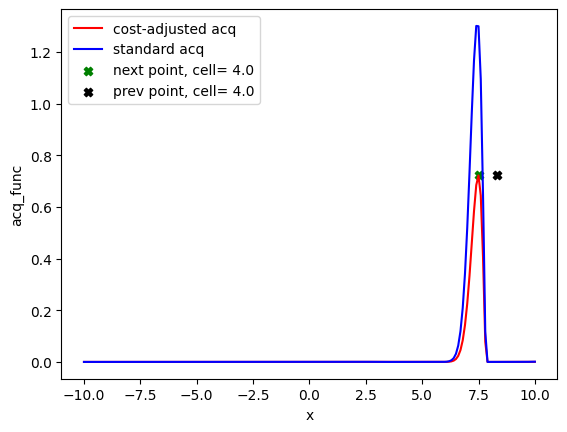

[108 109 110 111 112 113 143 144 149 146  16  19 180 183 175]


In [ ]:
N = 15
X_test =cxs
X_test_full = cxs
X_test_norm = np.zeros_like(X_test)
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])
X_test_norm[:, 1] = X_test[:, 1]
#train_x_norm = np.zeros_like(train_x)
#train_x_norm[:, 0] = (train_x[:, 0]-bounds[0])/(bounds[1]-bounds[0])
#train_x_norm[:, 1] = train_x[:, 1]

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
cost = np.zeros(N)
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_norm[:, 0], train_y, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[:, 0])
        plt.plot(xs, ys, label="ground truth", c="r")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        plt.plot(xs, y_pred, label="mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI",
        )
        plt.scatter(train_x[:, 0], train_y, c=train_x[:, 1], cmap="jet", marker="s", label="obs", s=100)

        plt.legend(loc="best")
        plt.show()
    # Compute the cost based acq function - EI based

    test_data = [X_test, X_test_norm]
    cost_params = [t_m, t_c, a, center]
    acq, next_point_idx, next_point_val,  cost[i-1] = cost_acqfun(gp_model, train_x, test_data, cost_params, rng_key_predict, idx, isnorm=True)

    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        next_point_norm = X_test_norm[next_point_idx]
        train_x_norm = np.vstack((train_x_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x, train_x_norm)
        train_y = objective(train_x[:, 0])



34.52366531993286


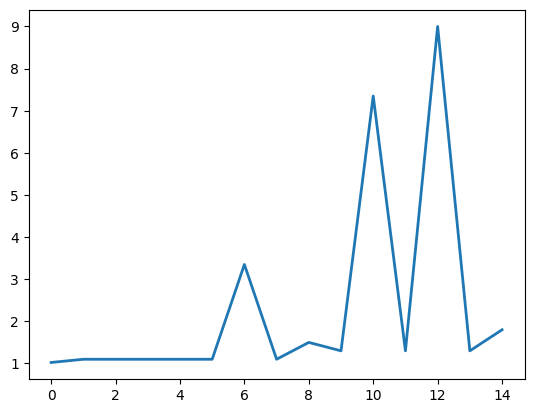

In [ ]:
total_cost= np.sum(cost)
print(total_cost)
plt.plot(cost, linewidth=2)

We can see due to the cost, the acq function tries to gradually exploiting the cells and once the exploitation is done, it focus on exploring the next cell with potential better solution (observed from the jump).

The height of the jump denotes the difference between the cells, where moving to the next cell has lesser cost than moving to the farther cells.

We can see the total cost for cBO is lower than standard BO for better cost awareness acquisition function

However, the cost related params need to be tuned for best outcome/trade-off between switching to different cells.

# Cost aware Structured BO

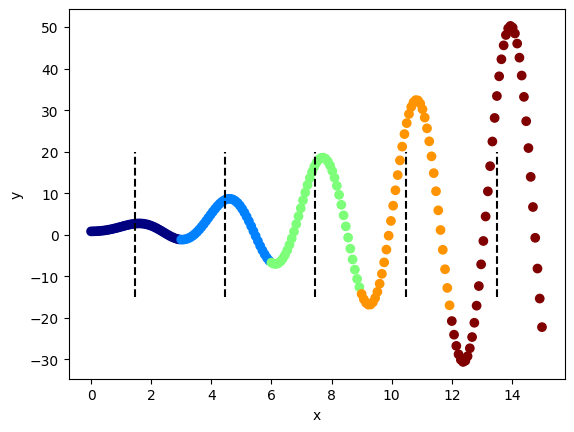

In [ ]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y

lb = 0
ub = 15
cell = np.array((0, 1,  2, 3, 4))

bounds = np.array((lb, ub), dtype=float)

xs = np.linspace(lb, ub, 201)
xs_norm = (xs-lb)/(ub-lb)

ys = objective(xs)
cxs = np.zeros((xs.shape[0], 2))
cxs[:, 0]=xs

for i in range(5):
  cxs[i*40:(i+1)*40 +1, 1]=cell[i]

center=np.zeros(5)
for i in range(5):
  center[i] = (np.max(cxs[cxs[:, 1]==i,0])+np.min(cxs[cxs[:, 1]==i,0]))/2

plt.scatter(cxs[:, 0], ys, c=cxs[:, 1], cmap="jet")
plt.vlines(center, ymin=-15, ymax=20, colors="k", linestyles="dashed")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Initial Sampling- 10 samples

In [ ]:
n = 10

np.random.seed(1)
train_xs = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_xs_norm = (train_xs-bounds[0])/(bounds[1]-bounds[0])
train_x = np.zeros((train_xs.shape[0], 2))
train_x_norm = np.zeros((train_xs_norm.shape[0], 2))
for i in range(train_xs.shape[0]):
  train_x[i, 0] = train_xs[i]
  train_x_norm[i, 0] = train_xs_norm[i]
  if train_xs[i]<=3:
    train_x[i, 1] = 0
    train_x_norm[i, 1] = 0
  if train_xs[i]>3 and train_xs[i]<=6:
    train_x[i, 1] = 1
    train_x_norm[i, 1] = 1
  if train_xs[i]>6 and train_xs[i]<=9:
    train_x[i, 1] = 2
    train_x_norm[i, 1] = 2
  if train_xs[i]>9 and train_xs[i]<=12:
    train_x[i, 1] = 3
    train_x_norm[i, 1] = 3
  if train_xs[i]>=12:
    train_x[i, 1] = 4
    train_x_norm[i, 1] = 4


train_xs, train_xs_norm, train_x, train_x_norm

(array([[6.25533007e+00],
        [1.08048674e+01],
        [1.71562226e-03],
        [4.53498859e+00],
        [2.20133836e+00],
        [1.38507892e+00],
        [2.79390317e+00],
        [5.18341091e+00],
        [5.95151211e+00],
        [8.08225101e+00]]),
 array([[4.17022005e-01],
        [7.20324493e-01],
        [1.14374817e-04],
        [3.02332573e-01],
        [1.46755891e-01],
        [9.23385948e-02],
        [1.86260211e-01],
        [3.45560727e-01],
        [3.96767474e-01],
        [5.38816734e-01]]),
 array([[6.25533007e+00, 2.00000000e+00],
        [1.08048674e+01, 3.00000000e+00],
        [1.71562226e-03, 0.00000000e+00],
        [4.53498859e+00, 1.00000000e+00],
        [2.20133836e+00, 0.00000000e+00],
        [1.38507892e+00, 0.00000000e+00],
        [2.79390317e+00, 0.00000000e+00],
        [5.18341091e+00, 1.00000000e+00],
        [5.95151211e+00, 1.00000000e+00],
        [8.08225101e+00, 2.00000000e+00]]),
 array([[4.17022005e-01, 2.00000000e+00],
        [7.2

In [ ]:
train_y = objective(train_x[:,0])
train_y

array([-6.71703894, 32.44078049,  0.81837548,  8.62193092,  1.48943872,
        2.59751537, -0.84606152,  4.2436293 , -6.41715175, 14.1322679 ])

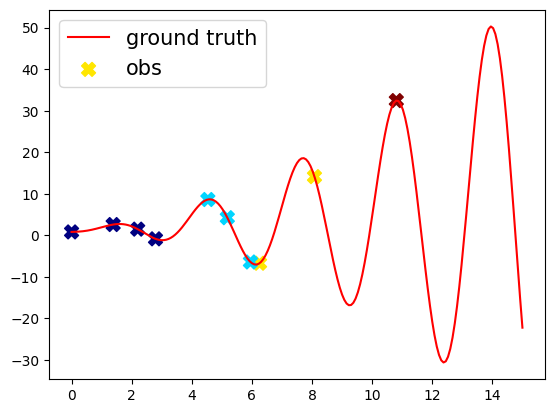

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x[:,0], train_y, c=train_x[:,1], cmap="jet", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

Run BO- 15 iterations

In [ ]:
t_m = 1
t_c = 2
a = 1

In [ ]:
@jit
def mean_func(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 15
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)

    return jnp.piecewise(
            x_data, [x_data < params["t"], x_data >= params["t"]],
            [lambda x_data: (params["a2"]*jnp.sin(x_data*params["a1"])),
             lambda x_data: (params["b2"]*jnp.sin(x_data*params["b1"]))])


def mf_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(10, 15))
    a1 = numpyro.sample("a1", numpyro.distributions.HalfNormal(1))
    b1 = numpyro.sample("b1", numpyro.distributions.HalfNormal(1))
    a2 = numpyro.sample("a2", numpyro.distributions.HalfNormal(1))
    b2 = numpyro.sample("b2", numpyro.distributions.HalfNormal(1))

    # Return sampled parameters as a dictionary
    return {"t": t, "a1": a1, "b1": b1, "a2": a2, "b2": b2}

Step:1


sample: 100%|██████████| 1000/1000 [00:05<00:00, 170.63it/s, 13 steps of size 1.36e-01. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.81      0.68      0.69      0.00      1.77    211.05      1.00
         a2      0.86      0.58      0.78      0.05      1.73    273.32      1.00
         b1      0.83      0.58      0.74      0.02      1.69    183.03      1.00
         b2      0.84      0.66      0.72      0.01      1.73    207.86      1.00
k_length[0]      1.32      1.41      0.82      0.06      3.24    317.67      1.00
    k_scale      3.05      9.23      1.27      0.07      6.07    146.32      1.01
      noise     78.81     28.55     72.36     40.10    121.31    234.45      1.00
          t     12.42      1.45     12.35     10.01     14.51    172.56      1.00



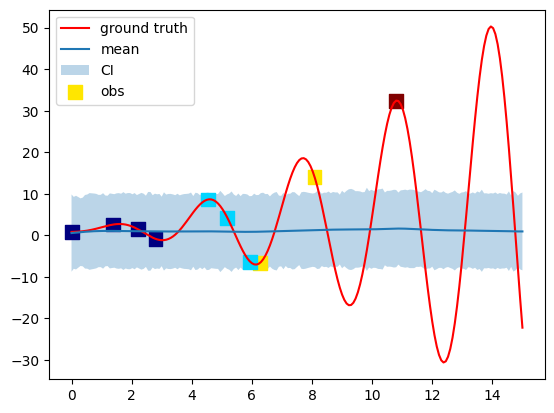

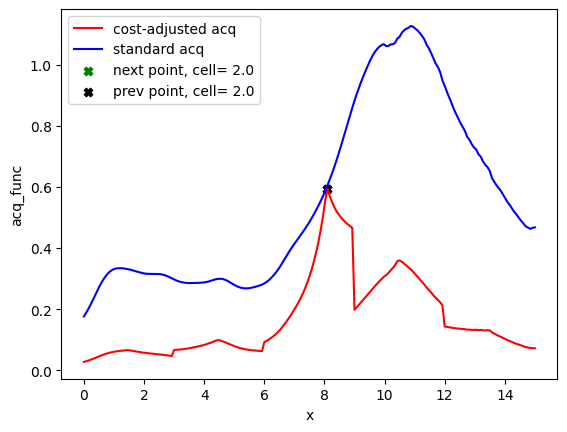

108
Step:2


sample: 100%|██████████| 1000/1000 [00:07<00:00, 139.62it/s, 15 steps of size 1.20e-01. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.90      0.67      0.74      0.08      1.89    198.23      1.02
         a2      0.88      0.63      0.74      0.02      1.85    242.51      1.00
         b1      0.83      0.61      0.69      0.01      1.74    281.40      1.00
         b2      0.80      0.64      0.67      0.01      1.73    138.79      1.00
k_length[0]      0.34      0.90      0.11      0.04      0.91     18.44      1.07
    k_scale     85.49     52.88     87.79      0.08    146.55     10.50      1.11
      noise     13.97     29.59      0.97      0.09     67.49      6.20      1.22
          t     12.58      1.38     12.67     10.28     14.67    244.23      1.00



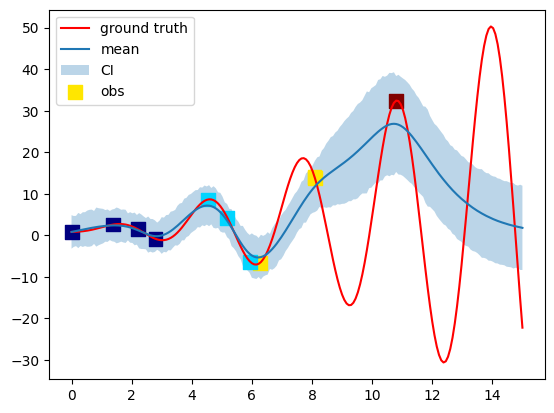

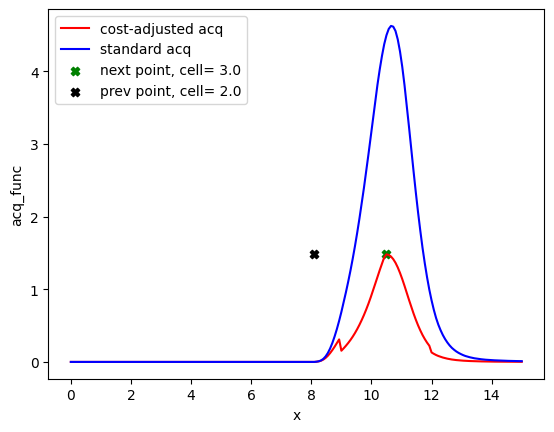

[108 140]
Step:3


sample: 100%|██████████| 1000/1000 [00:06<00:00, 164.05it/s, 15 steps of size 1.20e-01. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.86      0.65      0.72      0.07      1.85    193.05      1.00
         a2      0.83      0.56      0.76      0.03      1.61    323.63      1.00
         b1      0.85      0.59      0.77      0.00      1.66    218.61      1.01
         b2      0.74      0.60      0.62      0.00      1.59    371.26      1.00
k_length[0]      0.09      0.02      0.09      0.05      0.13    345.92      1.00
    k_scale    100.66     41.71     90.67     49.63    160.25    216.14      1.00
      noise      1.20      1.34      0.73      0.08      2.72    225.56      1.01
          t     12.62      1.43     12.57     10.41     14.79    242.23      1.00



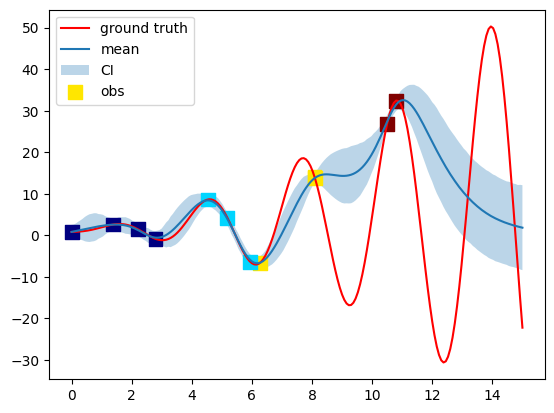

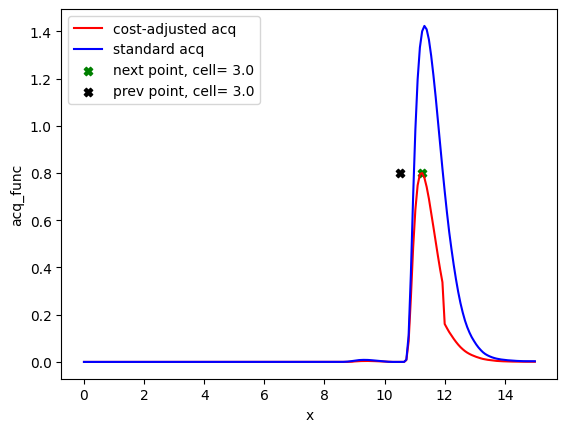

[108 140 150]
Step:4


sample: 100%|██████████| 1000/1000 [00:06<00:00, 162.97it/s, 19 steps of size 6.97e-02. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.85      0.67      0.70      0.00      1.78    205.96      1.00
         a2      0.87      0.61      0.76      0.02      1.78    245.43      1.00
         b1      0.84      0.62      0.66      0.01      1.78    296.03      1.00
         b2      0.84      0.65      0.70      0.01      1.77    272.96      1.00
k_length[0]      0.08      0.04      0.07      0.04      0.12     97.05      1.01
    k_scale     84.57     34.78     76.50     39.98    127.67    120.26      1.01
      noise      2.76      3.58      1.68      0.05      5.91    134.04      1.00
          t     12.36      1.44     12.40     10.04     14.39    243.27      1.01



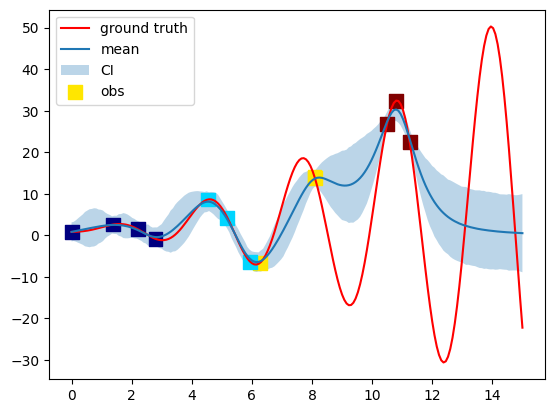

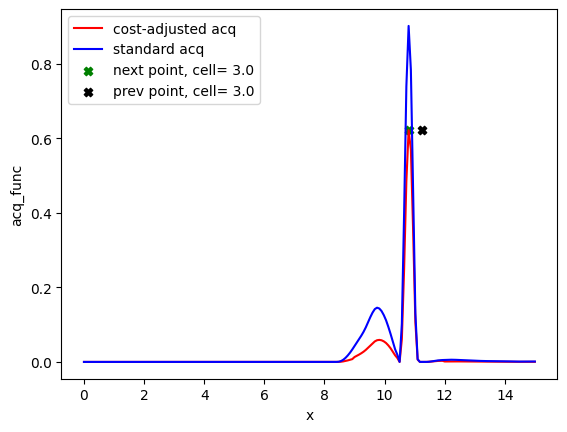

[108 140 150 144]
Step:5


sample: 100%|██████████| 1000/1000 [00:06<00:00, 164.34it/s, 15 steps of size 1.14e-01. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.90      0.64      0.75      0.03      1.84    188.77      1.00
         a2      0.78      0.59      0.66      0.03      1.65    306.64      1.00
         b1      0.79      0.59      0.64      0.01      1.70    186.97      1.00
         b2      0.86      0.66      0.73      0.00      1.82    186.63      1.01
k_length[0]      0.06      0.01      0.06      0.04      0.08    135.16      1.00
    k_scale     84.40     32.14     78.01     39.52    126.42    234.63      1.01
      noise      0.83      1.11      0.49      0.04      1.77    125.06      1.00
          t     12.30      1.44     12.14     10.06     14.42    157.07      1.00



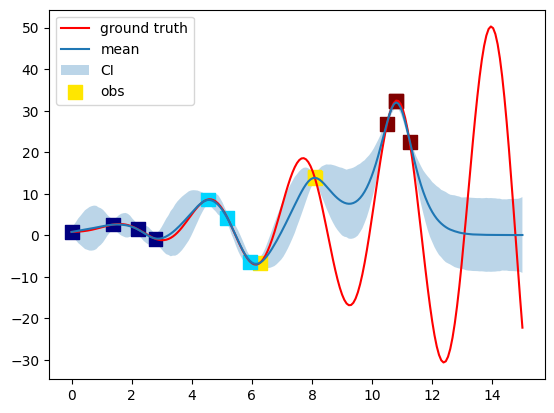

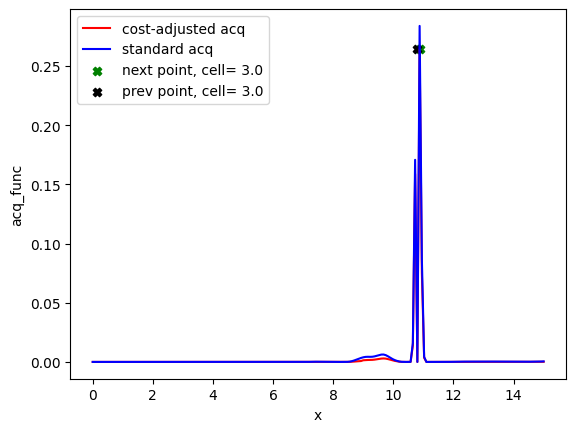

[108 140 150 144 145]
Step:6


sample: 100%|██████████| 1000/1000 [00:05<00:00, 169.78it/s, 12 steps of size 1.18e-01. acc. prob=0.75]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.81      0.64      0.68      0.03      1.79    161.15      1.00
         a2      0.83      0.63      0.70      0.00      1.72    182.65      1.00
         b1      0.83      0.61      0.71      0.01      1.65    401.47      1.00
         b2      0.83      0.64      0.68      0.01      1.74    201.81      1.00
k_length[0]      0.06      0.01      0.06      0.04      0.07    157.59      1.00
    k_scale     85.48     31.08     79.81     36.50    126.53    201.06      1.00
      noise      0.54      0.75      0.31      0.04      1.09     84.37      1.00
          t     12.71      1.45     12.77     10.65     15.00    169.03      1.00



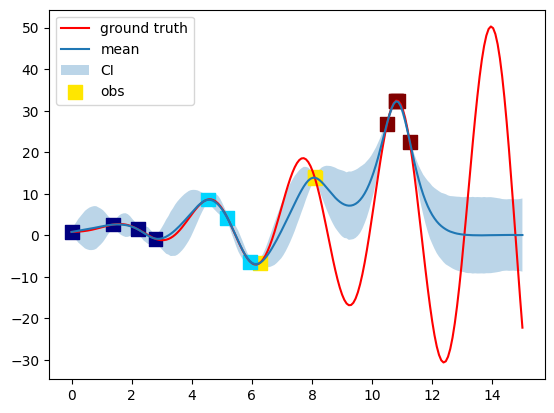

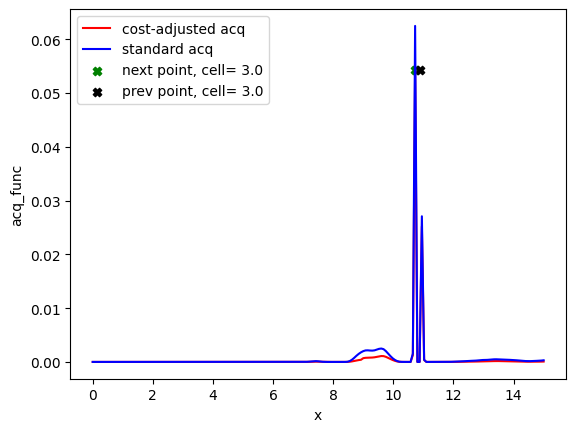

[108 140 150 144 145 143]
Step:7


sample: 100%|██████████| 1000/1000 [00:06<00:00, 159.31it/s, 15 steps of size 1.01e-01. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.68      0.58      0.58      0.00      1.62    114.45      1.00
         a2      0.92      0.65      0.81      0.01      1.75    688.34      1.00
         b1      0.81      0.61      0.64      0.01      1.72    293.75      1.00
         b2      0.90      0.62      0.79      0.01      1.70    260.37      1.00
k_length[0]      0.06      0.01      0.06      0.04      0.07     77.97      1.01
    k_scale     84.54     33.68     76.98     40.44    136.05    240.66      1.00
      noise      0.43      0.78      0.24      0.03      0.76     65.25      1.01
          t     12.44      1.37     12.37     10.60     14.90    201.22      1.01



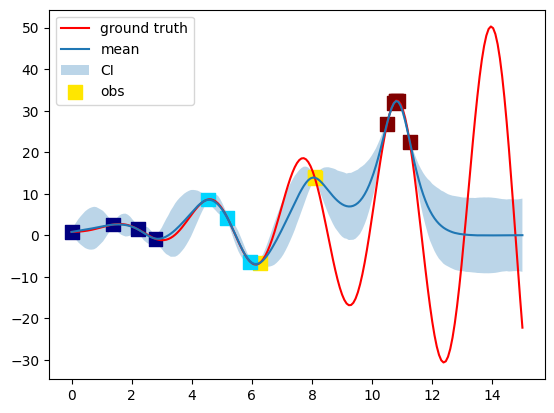

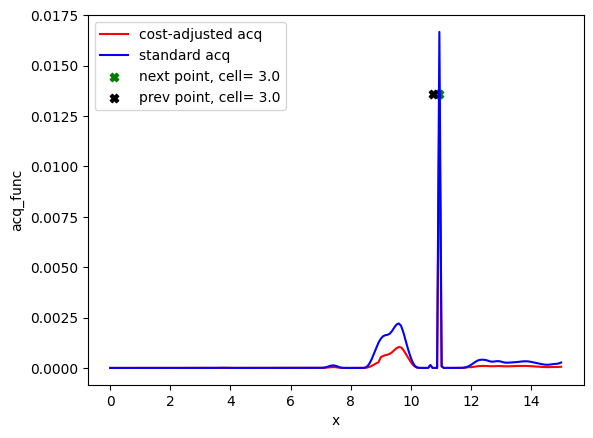

[108 140 150 144 145 143 146]
Step:8


sample: 100%|██████████| 1000/1000 [00:06<00:00, 143.47it/s, 19 steps of size 7.58e-02. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.76      0.61      0.65      0.01      1.74    224.12      1.00
         a2      0.82      0.64      0.67      0.01      1.75    403.93      1.00
         b1      0.78      0.60      0.63      0.00      1.65    286.47      1.00
         b2      0.84      0.65      0.71      0.00      1.78    377.64      1.00
k_length[0]      0.05      0.01      0.06      0.04      0.07    227.91      1.00
    k_scale     81.55     29.56     74.99     40.20    127.20    217.92      1.00
      noise      0.24      0.22      0.18      0.02      0.50    208.87      1.00
          t     12.56      1.38     12.60     10.58     14.94    194.84      1.00



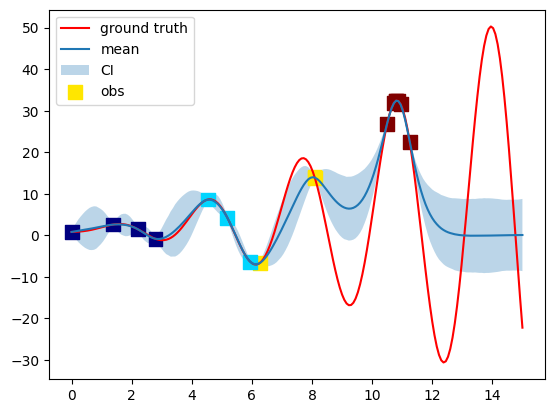

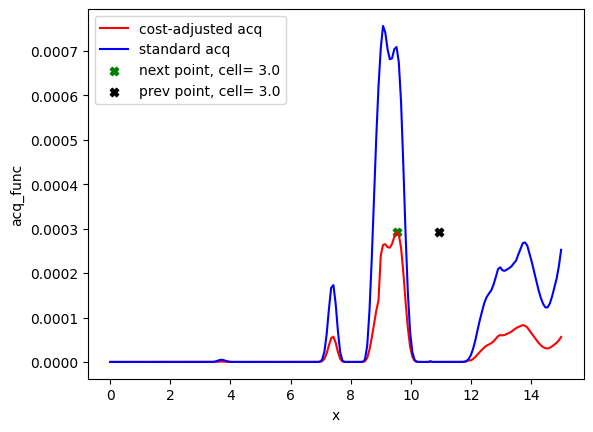

[108 140 150 144 145 143 146 127]
Step:9


sample: 100%|██████████| 1000/1000 [00:06<00:00, 143.43it/s, 15 steps of size 8.11e-02. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.88      0.62      0.75      0.10      1.88    132.96      1.00
         a2      0.94      0.66      0.82      0.01      1.90    138.89      1.00
         b1      0.83      0.62      0.66      0.01      1.81    228.07      1.00
         b2      0.89      0.60      0.77      0.01      1.80    292.32      1.00
k_length[0]      0.05      0.01      0.05      0.03      0.06     94.81      1.00
    k_scale     98.23     35.67     90.55     51.94    143.15    169.49      1.00
      noise      0.26      0.32      0.17      0.02      0.54    220.94      1.02
          t     12.48      1.38     12.58     10.07     14.34    146.55      1.00



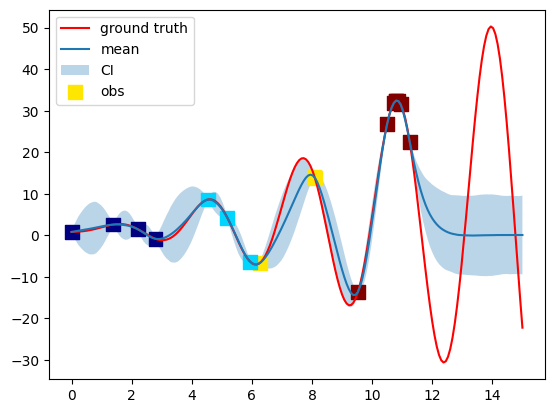

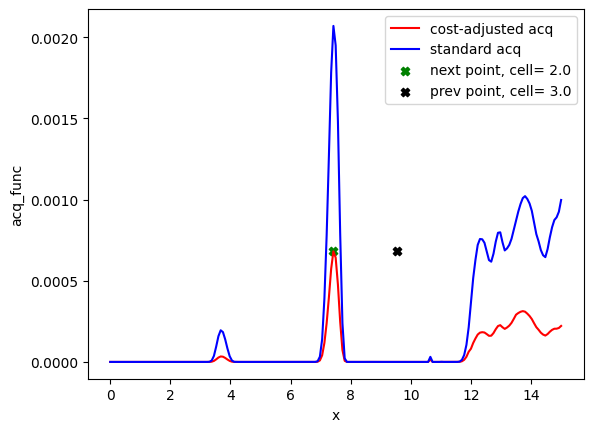

[108 140 150 144 145 143 146 127  99]
Step:10


sample: 100%|██████████| 1000/1000 [00:07<00:00, 135.91it/s, 14 steps of size 1.17e-01. acc. prob=0.70]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.92      0.60      0.84      0.03      1.86    127.19      1.00
         a2      0.96      0.82      0.74      0.03      1.96     38.24      1.03
         b1      0.78      0.56      0.64      0.00      1.57    202.96      1.01
         b2      0.81      0.54      0.73      0.01      1.61    242.09      1.00
k_length[0]      0.05      0.01      0.05      0.04      0.07    209.78      1.00
    k_scale     98.43     31.62     91.68     54.28    144.61    183.48      1.00
      noise      0.21      0.19      0.14      0.01      0.43    303.38      1.00
          t     12.47      1.42     12.43     10.07     14.51    100.06      1.00



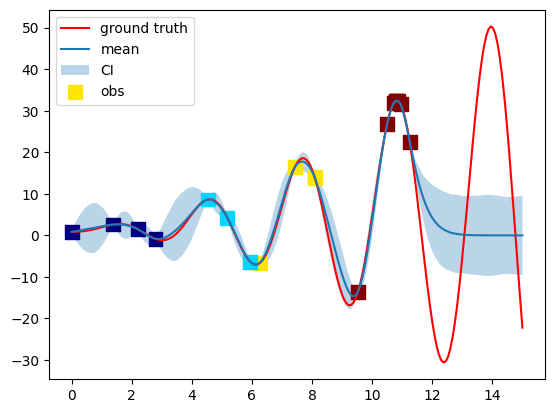

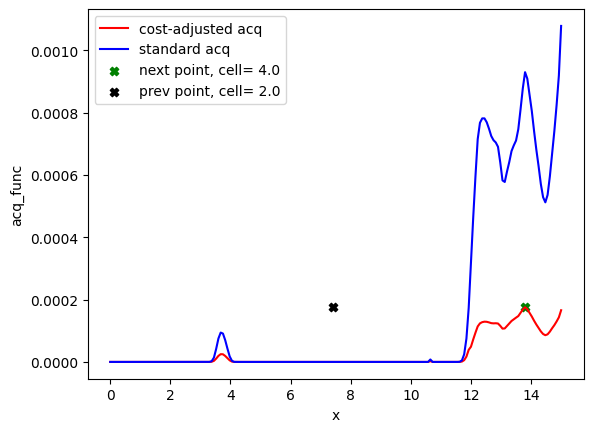

[108 140 150 144 145 143 146 127  99 184]
Step:11


sample: 100%|██████████| 1000/1000 [00:07<00:00, 139.02it/s, 23 steps of size 6.37e-02. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.79      0.53      0.74      0.00      1.51    224.37      1.00
         a2      0.81      0.60      0.70      0.02      1.67    362.35      1.00
         b1      0.79      0.60      0.65      0.00      1.67    239.03      1.00
         b2      0.85      0.67      0.68      0.01      1.79    254.60      1.00
k_length[0]      0.06      0.01      0.06      0.05      0.08    173.43      1.00
    k_scale    229.26     84.69    209.34    102.63    349.61    179.09      1.00
      noise      0.22      0.23      0.15      0.01      0.47    217.28      1.01
          t     12.41      1.45     12.41     10.04     14.50    243.89      1.00



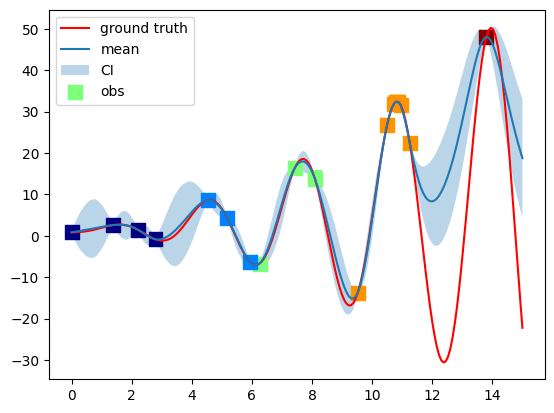

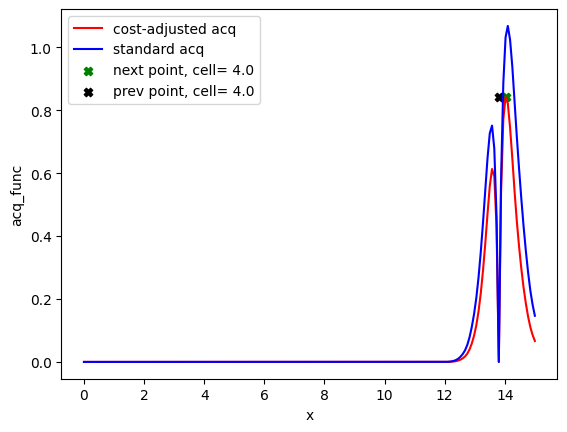

[108 140 150 144 145 143 146 127  99 184 187]
Step:12


sample: 100%|██████████| 1000/1000 [00:07<00:00, 141.04it/s, 31 steps of size 1.03e-01. acc. prob=0.72]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.86      0.64      0.71      0.03      1.84     83.10      1.00
         a2      0.87      0.62      0.73      0.03      1.83    123.70      1.00
         b1      0.79      0.62      0.61      0.00      1.75    113.02      1.00
         b2      0.88      0.66      0.76      0.00      1.88    276.35      1.01
k_length[0]      0.07      0.01      0.07      0.05      0.08    128.91      1.02
    k_scale    218.36     69.37    210.10    108.80    304.74    147.17      1.01
      noise      0.23      0.23      0.16      0.02      0.49     85.28      1.01
          t     12.68      1.50     12.66     10.36     14.89    101.79      1.00



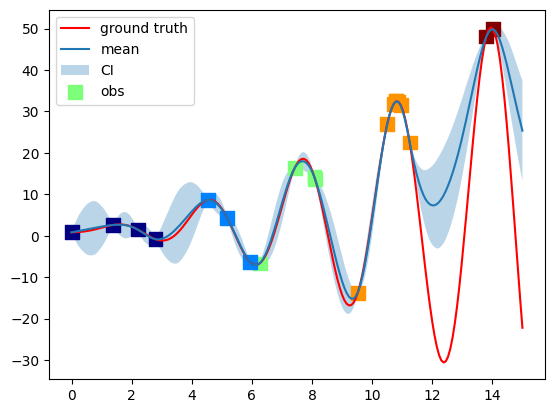

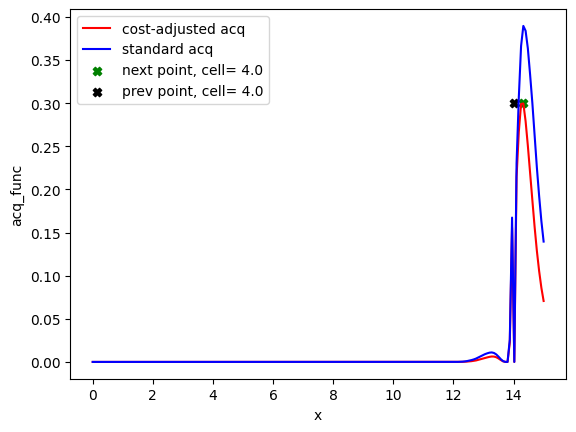

[108 140 150 144 145 143 146 127  99 184 187 191]
Step:13


sample: 100%|██████████| 1000/1000 [00:08<00:00, 124.09it/s, 15 steps of size 8.05e-02. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.73      0.57      0.59      0.03      1.59    244.32      1.00
         a2      0.80      0.56      0.73      0.01      1.68    273.35      1.00
         b1      0.79      0.58      0.67      0.02      1.65    276.53      1.00
         b2      0.83      0.65      0.68      0.01      1.78    132.58      1.00
k_length[0]      0.06      0.01      0.06      0.04      0.07    202.13      1.00
    k_scale    199.02     61.35    191.88    110.54    284.90    211.14      1.00
      noise      0.27      0.32      0.17      0.01      0.58    164.15      1.01
          t     12.62      1.39     12.65     10.45     14.90    279.75      1.00



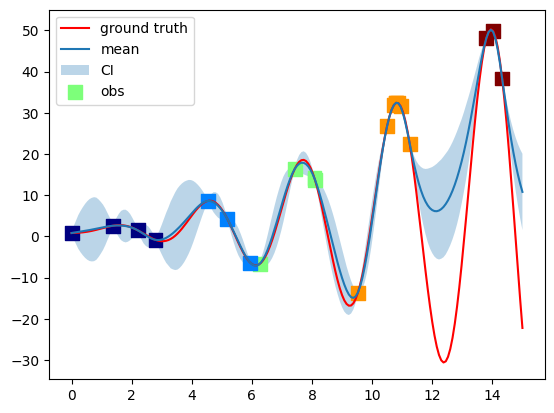

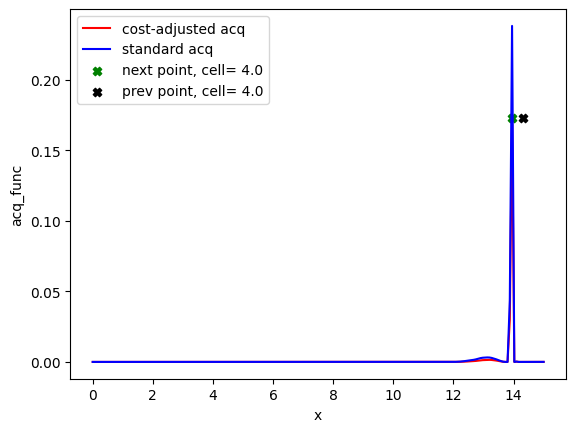

[108 140 150 144 145 143 146 127  99 184 187 191 186]
Step:14


sample: 100%|██████████| 1000/1000 [00:11<00:00, 83.83it/s, 63 steps of size 3.36e-02. acc. prob=0.85] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.78      0.65      0.58      0.00      1.82    205.75      1.01
         a2      0.78      0.63      0.66      0.01      1.74    143.56      1.00
         b1      0.84      0.57      0.73      0.01      1.61    252.78      1.00
         b2      0.81      0.62      0.64      0.00      1.72    226.23      1.00
k_length[0]      0.06      0.01      0.06      0.04      0.07    232.09      1.01
    k_scale    197.18     57.77    189.17    104.20    286.67    302.67      1.00
      noise      0.17      0.15      0.12      0.02      0.35    290.72      1.00
          t     12.57      1.40     12.64     10.03     14.46    281.05      1.00



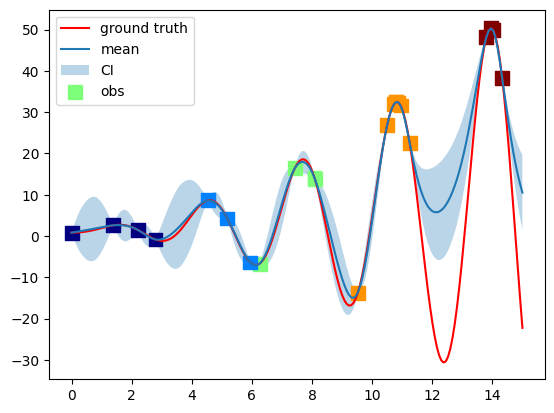

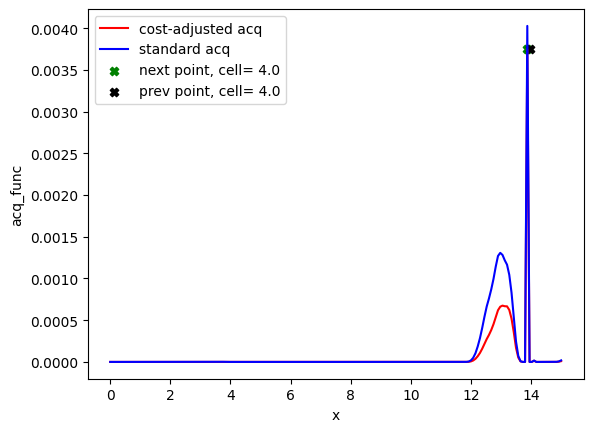

[108 140 150 144 145 143 146 127  99 184 187 191 186 185]
Step:15


sample: 100%|██████████| 1000/1000 [00:19<00:00, 50.16it/s, 255 steps of size 5.20e-03. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.80      0.65      0.61      0.00      1.80    225.70      1.00
         a2      0.79      0.62      0.63      0.00      1.64    330.52      1.02
         b1      0.75      0.57      0.64      0.00      1.61    346.84      1.00
         b2      0.81      0.59      0.72      0.00      1.60    301.35      1.00
k_length[0]      0.06      0.01      0.06      0.05      0.07    174.85      1.01
    k_scale    198.14     63.70    187.25    108.75    286.47    175.02      1.02
      noise      0.12      0.12      0.09      0.01      0.27    199.65      1.00
          t     12.53      1.36     12.56     10.12     14.50    265.45      1.00



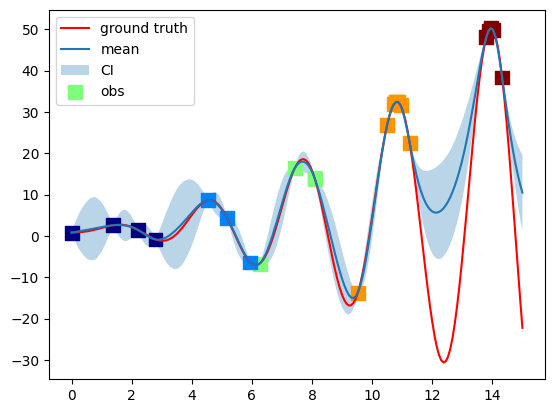

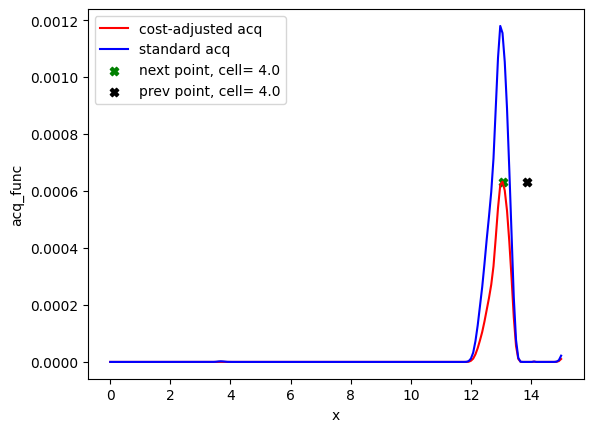

[108 140 150 144 145 143 146 127  99 184 187 191 186 185 174]


In [ ]:
N = 15
X_test =cxs
X_test_full = cxs
X_test_norm = np.zeros_like(X_test)
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])
X_test_norm[:, 1] = X_test[:, 1]
#train_x_norm = np.zeros_like(train_x)
#train_x_norm[:, 0] = (train_x[:, 0]-bounds[0])/(bounds[1]-bounds[0])
#train_x_norm[:, 1] = train_x[:, 1]

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
cost = np.zeros(N)
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='Matern',mean_fn=mean_func, mean_fn_prior=mf_priors)
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_norm[:, 0], train_y, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[:, 0])
        plt.plot(xs, ys, label="ground truth", c="r")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        plt.plot(xs, y_pred, label="mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI",
        )
        plt.scatter(train_x[:, 0], train_y, c=train_x[:, 1], cmap="jet", marker="s", label="obs", s=100)

        plt.legend(loc="best")
        plt.show()
    # Compute the cost based acq function - EI based

    test_data = [X_test, X_test_norm]
    cost_params = [t_m, t_c, a, center]
    acq, next_point_idx, next_point_val,  cost[i-1] = cost_acqfun(gp_model, train_x, test_data, cost_params, rng_key_predict, idx, isnorm=True)

    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        next_point_norm = X_test_norm[next_point_idx]
        train_x_norm = np.vstack((train_x_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x, train_x_norm)
        train_y = objective(train_x[:, 0])



28.267748989949645


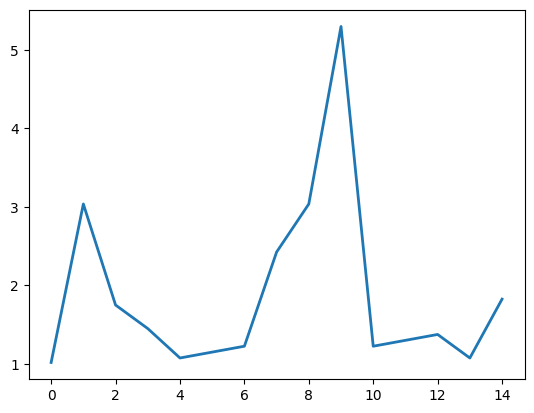

In [ ]:
total_cost= np.sum(cost)
print(total_cost)
plt.plot(cost, linewidth=2)